In [1]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-

In [2]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
pd.set_option('display.max_column',100)
pd.set_option('display.max_row',5000)
from pandas import DataFrame
from pandas import concat
import re
import math

import requests
from bs4 import BeautifulSoup

In [3]:
#현재 데이터에서 발생하는 type error를 해결하기 위한 함수 생성해둠

def coerce_df_columns_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')

In [4]:
regular=pd.read_csv(r"C:\Users\bluedice\Desktop\Regular_Season_Batter.csv")
rsbd=pd.read_csv(r"C:\Users\bluedice\Desktop\Regular_Season_Batter_Day_by_Day.csv")
submission=pd.read_csv(r"C:\Users\bluedice\Desktop\submission.csv")

0. 데이터 확인

프리 시즌에 나서는 타자들은 주전 뿐만 아니라 신예들도 많기 때문에 정규 시즌에 나서지 못하는 타자들이 많고 아예 신예 선수들은 엔트리가 확장되는 후반기에 출전하거나 주전 선수들이 모두 부상인 경우가 아니면 출전을 잘 안하여서 프리시즌 자료는 사용하지 않기로 하였다

In [5]:
regular.head(3) #사전에 정규시즌이 어떻게 입력되어있는지 파악하기 위한 용도로 사용함

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686


In [6]:
regular.describe() #해당 자료의 결측치 여부, 숫자,문자형 여부 확인용으로 사용하였음

,batter_id,year,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,2454.000000,2454.000000,2428.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2428.000000,2430.000000,2454.000000,2428.000000
mean,178.079462,2011.614507,0.237559,72.535045,201.514670,29.912388,55.988183,9.863488,0.957620,5.504075,84.279136,27.788509,5.290139,2.335778,20.943765,3.424613,38.596985,4.603504,0.343826,0.306684,3.676447,0.649939
std,97.557947,4.992833,0.098440,45.093871,169.537029,28.778759,52.253844,9.871314,1.647193,7.989380,82.854200,29.602966,9.088580,3.194045,21.206113,4.132614,31.801466,4.713531,0.163335,0.111778,4.585248,0.261634
min,0.000000,1993.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101.250000,2008.000000,0.203000,28.000000,38.250000,5.000000,8.000000,1.000000,0.000000,0.000000,10.000000,3.000000,0.000000,0.000000,3.000000,0.000000,10.000000,1.000000,0.267454,0.272727,0.000000,0.546000
50%,183.000000,2013.000000,0.255000,79.000000,163.000000,21.000000,40.000000,7.000000,0.000000,2.000000,56.000000,17.000000,2.000000,1.000000,14.000000,2.000000,33.000000,3.000000,0.360124,0.328592,2.000000,0.688637
75%,265.000000,2016.000000,0.291000,115.000000,357.500000,49.000000,100.000000,16.000000,1.000000,8.000000,146.000000,44.000000,6.000000,3.000000,34.000000,5.000000,60.000000,7.000000,0.436000,0.367000,5.000000,0.797234
max,344.000000,2018.000000,1.000000,144.000000,600.000000,135.000000,201.000000,47.000000,17.000000,53.000000,377.000000,146.000000,84.000000,21.000000,108.000000,27.000000,161.000000,24.000000,3.000000,1.000000,30.000000,4.000000


현재 kbo 데이터가 존재하는 스탯티즈와 비교한 결과, PA가 없으며, obp에 쓰이는 희생플라이, 나이, 고의사구, 희생번트, 연봉, war이 없어 이를 크롤링 하기로 결정하였다 

기존 자료에서는 batter_id의 경우 타자 고유의 번호 이므로 의미가 없다고 보며, 
분리가 가능할 것으로 보이는 변수들로는 height/weight 그리고 position에서의 포지션과
해당 선수의 타석위치 정도로 파악이 된 상태이다.

0. 사전 자료 파악 (2018년도 정규시즌 선수와 submission 선수들의 동일성 파악)

일단 목표 과제인 submission 타자들의 19시즌 전반기 ops를 예측하는 것이 목표이기 때문에
가장 최근 시즌인 18시즌과 submission 타자들의 이름이 얼마나 동일한지 확인 해 보았다.

In [7]:
submission_unique=DataFrame(submission['batter_name'].drop_duplicates(),columns=['batter_name']) #서브미션 이름 중복값 제거

kk=regular.loc[regular['year']==2018,'batter_name'] #2018년도 정규시즌 타자들 이름 생성
kk=kk.unique() #이름 중복값 제거
kkk=DataFrame(kk,columns=['batter_name']) #비교하기 위해서 dataframe 화

merge2=kkk.merge(submission_unique, how='outer', indicator=True) 
#두 데이터프레임을 merge해서 right_only나 left_only가 나오면 한 쪽에 존재하지 않는 선수임
merge2['_merge'].value_counts()

both          227
right_only      0
left_only       0
Name: _merge, dtype: int64

기존에는 submission에 220명이 존재하였는데 자료 수정 이후에는 227명 모두가 18시즌에 존재함을 확인하였다. 즉 submission은 18시즌에 나온 타자들 전체를 대상으로 한다.

1. 결과변수 생성(YOPS,YAB)

현재 19시즌 전반기 선수들의 ops를 예측하기 위해서는 train set으로 18년도까지의 각 선수들의 전반기 성적이 필요하다고 생각하였다.

18시즌까지의 일자별 자료를 이용 및 각 연도별 전반기 날짜를 파악후, 결과변수로 YOPS를 생성하고 wrmse에 사용이 될 전반기 타석수인 YAB도 생성하였다. 

In [8]:
rsbd['part']='반기' #part는 전반기,후반기 구분 변수로 임의로 '반기'라는 문자를 투입함

#현재 2001년 부터 2018년 까지의 해당 연도의 전반기 일정을 리스트로 생성함
year=list(range(2001,2019)) #2001년부터 2018년
day=[7.15,7.14,7.13,7.14,7.14,7.20,7.15,7.31,7.23,7.22,7.21,7.19,7.17,7.16,7.16,7.14,7.13,7.12] #2001.07.15 ~2018.07.12

#for 문장을 이용하여서 해당 날짜 이하 면 전반기, 초과면 후반기로 대체하였다. 
for x,y in zip(year,day): 
    rsbd.loc[ (rsbd['year']==[x]) & ( rsbd['date']<=[y] ) ,'part']='전반기'
    rsbd.loc[ (rsbd['year']==[x]) & ( rsbd['date']>[y] ) ,'part']='후반기'
    
rsbd['part'].unique() #전반기 후반기가 잘 나뉘었음을 확인가능하다

array(['전반기', '후반기'], dtype=object)

In [9]:
#groupby를 사용하여서 이름,분기,연도별로 해당 변수들의 합을 구함
rsbd_part=rsbd.groupby(['batter_name','part','year'])['AB','H', '2B', '3B', 'HR', 'BB', 'HBP'].sum()

#YOPS를 만들기 위해서 필요한 변수들을 만드는 작업을 실시함
rsbd_part['1B']=rsbd_part['H']-rsbd_part['2B']-rsbd_part['3B']-rsbd_part['HR']
rsbd_part['TB']=rsbd_part['1B']+2*rsbd_part['2B']+3*rsbd_part['3B']+4*rsbd_part['HR']
rsbd_part['FBP']=rsbd_part['BB']+rsbd_part['HBP']
rsbd_part['avg']=round(rsbd_part['H']/rsbd_part['AB'],3)
rsbd_part['OBP']=round( (rsbd_part['H']+rsbd_part['FBP'])/(rsbd_part['AB']+rsbd_part['FBP']) ,3)
rsbd_part['SLG']=round( rsbd_part['TB']/rsbd_part['AB'],3)
rsbd_part['OPS']=rsbd_part['SLG']+rsbd_part['OBP']

#groupby를 한 rsbd_part에서 변수들을 편하게 빼기 위해서 csv파일로 잠시 내보냄
rsbd_part.to_csv('C:\\Users\\bluedice\\Desktop\\rsbd_part.csv', sep=',',  na_rep='NaN')

2. YAB, YOPS 통합 작업

현재 train,test set으로 사용이 가능한 observation들만 남겨둔 상태로 다음 작업을 실시하려고 한다.

In [10]:
rsbd_part=pd.read_csv(r"C:\Users\bluedice\Desktop\rsbd_part.csv") #groupby가 진행된 엑셀을 다시 불러와서 사용

rsbd_part1=rsbd_part.loc[rsbd_part['part']=='전반기',['batter_name','year','AB','OPS']] #regular 자료에 합치는데 필요한 변수들만 추출

In [11]:
rsbd_part1=rsbd_part1.rename({'AB':'YAB'},axis='columns') #regular 자료와 중복 방지 위해서 이름 변경
rsbd_part1=rsbd_part1.rename({'year':'p_year'},axis='columns')
rsbd_part1=rsbd_part1.rename({'OPS':'YOPS'},axis='columns') #regular 자료와 중복 방지 위해서 이름 변경

coerce_df_columns_to_numeric(rsbd_part1,'p_year') #문자열로 인식된 p_year를 숫자로 변경

In [12]:
regular['p_year']=regular['year']+1 #다음 시즌과 결합을 시켜야되기 때문에 기존 연도에 1을 더해 다음 시즌 연도를 만듦

regular_y=pd.merge(regular,rsbd_part1,on=['batter_name','p_year'])

In [13]:
regular_y.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,p_year,YAB,YOPS
0,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686,2015,156,0.679
1,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673,2016,81,0.447
2,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489,2017,82,0.542
3,1,강경학,2017,한화,0.214,59,84,17,18,2,1,0,22,4,1,1,8,1,19,1,0.262,0.290,4,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.552,2018,115,0.921
4,2,강구성,2015,NC,0.200,4,5,0,1,1,0,0,2,0,0,0,0,0,0,0,0.400,0.200,0,180cm/82kg,1993년 06월 09일,외야수(우투좌타),관산초-부천중-야탑고-NC-상무,9000만원,0.600,2016,2,0.000


In [14]:
r2018=regular.loc[regular['year']==2018,:] #위의 결합을 실행하면 값이 없는 2018년도의 경우 제외되는 문제가 생긴다.

In [15]:
r2018.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,p_year
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,2019
6,1,강경학,2018,한화,0.278,77,245,42,68,11,1,5,96,27,6,3,38,4,59,7,0.392,0.382,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.774,2019
11,2,강구성,2018,NC,0.200,4,5,0,1,1,0,0,2,1,0,0,0,0,3,0,0.400,0.200,0,180cm/82kg,1993년 06월 09일,외야수(우투좌타),관산초-부천중-야탑고-NC-상무,9000만원,0.600,2019
41,3,강민국,2018,NC,0.250,6,4,0,1,0,0,0,1,0,0,0,0,0,0,0,0.250,0.250,0,176cm/80kg,1992년 01월 10일,내야수(우투우타),송정동초-충장중-광주제일고-동국대-NC-상무,20000만원,0.500,2019
56,4,강민호,2018,삼성,0.269,129,427,46,115,14,0,22,195,71,0,0,29,14,96,11,0.457,0.331,8,185cm/100kg,1985년 08월 18일,포수(우투우타),제주신광초-포철중-포철공고-(국제디지털대)-롯데,9000만원,0.788,2019


In [16]:
regular_full_y=pd.concat([regular_y,r2018],axis=0) #이를 해결하기 위해 따로 뽑고 다시 합쳤다.

C:\Users\bluedice\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [17]:
col=['batter_id', 'batter_name', 'year', 'team', 'height/weight',  'position', 
 'G', 'AB', 'H', '2B', '3B', 'HR', 'TB', 'SB', 'CS',  'BB', 'HBP',
'R','RBI', 'E', 'SO', 'GDP', 'avg', 'OBP','SLG','OPS','career', 'starting_salary','year_born','p_year','YAB','YOPS']

regular_full_y=DataFrame(regular_full_y,columns=col) #2018년도와 결합하면 열이 재정렬 되버리기 때문에 이를 수정해주었음
regular_full_y=regular_full_y.reset_index(drop=True) #2018년도의 index와 중복을 방지하기 위해 초기화 실시

In [18]:
regular_full_y.to_csv("C:\\Users\\bluedice\\Desktop\\regular_full_y.csv")

2. regular_season_batter 사전 골라내기 작업 및 변경 작업

현재 정규시즌 자료에서 분리가 가능한 변수(키/몸무게) 분리 작업 및 팀 같은 경우는 명칭 변경 전 값들과 합쳐진 경우가 있어 이를 수정 하는 과정을 거치려고 한다.

2-1 height/weight의 경우 결측치가 존재하지만 결측치가 아닌 경우에는 충분히 분리가 가능하다.

In [19]:
regular_full_y['height/weight']=regular_full_y['height/weight'].fillna(0) # NaN을 0으로 처리

regular_full_y['height']=200 #height라는 변수를 만들고 임의값으로 200 지정
regular_full_y['weight']=100 #weight라는 변수를 만들고 임의값으로 100 지정

for i in range(0,len(regular_full_y)):
    regular_full_y['height'][i]=regular_full_y['height/weight'][i].split('/')[0] #/기준으로 왼쪽이 height
    regular_full_y['weight'][i]=regular_full_y['height/weight'][i].split('/')[1] #으론쪽이 weight
    regular_full_y['height'][i]=regular_full_y['height'][i].split('c')[0] #여기서 또 c를 기준으로 왼쪽이 키에 대한 숫자 값
    regular_full_y['weight'][i]=regular_full_y['weight'][i].split('k')[0] #k를 기준으로 왼쪽이 몸무게 숫자값
        
del regular_full_y['height/weight'] #분리한 변수는 더이상 필요 없으므로 삭제한다
coerce_df_columns_to_numeric(regular_full_y,'height') #문자로 인식된 키 변수를 숫자로 변경
coerce_df_columns_to_numeric(regular_full_y,'weight') #문자로 인식된 몸무게 변수를 숫자로 변경

C:\Users\bluedice\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\bluedice\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\bluedice\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\bluedice\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWi

2-2 현재 kbo의 경우 10개의 팀이 존재하는데 현 키움(넥센)의 경우 우리, 현대, 히어로즈 등의 다른 이름을 가지고 있었다

이러한 이름의 변경은 데이터를 분석하는데 문제가 된다고 판단이 되어 현재의 팀명으로 다시 바꾸어 주는 작업을 실시하였다

In [20]:
regular_full_y['team'].unique() #기존 팀명들 중복 제거값 출력

array(['한화', 'NC', '롯데', 'LG', 'KIA', '삼성', '넥센', '두산', 'SK', 'KT',
       '히어로즈', '우리', '현대'], dtype=object)

In [21]:
regular_full_y['team']=regular_full_y['team'].replace('우리','키움') #키움의 전 명칭들을 키움으로 통합
regular_full_y['team']=regular_full_y['team'].replace('현대','키움')
regular_full_y['team']=regular_full_y['team'].replace('히어로즈','키움')
regular_full_y['team']=regular_full_y['team'].replace('넥센','키움')

regular_full_y['team'].unique() #문제가 해결된 모습을 보인다.

array(['한화', 'NC', '롯데', 'LG', 'KIA', '삼성', '키움', '두산', 'SK', 'KT'],
      dtype=object)

3. 현재 스탯티즈를 통해서 추가적인 변수를 크롤링 하는 것이 가능하며, 그 이외에 현재 야구를 분석할때 자주 사용이 되는 혹은 유명한 변수들의 경우, 공식을 통해서 구할 예정이다

3-1 현재 안타수, 2,3,홈런 등은 기록이 있지만 1루타에 대한 변수가 없으며
도루의 경우도 성공,실패로 분리가 되어있고, 4사구의 경우도 볼넷,사구로 나뉘어 있어 해당 변수를 생성하였다

In [22]:
#1루타 만들기
regular_full_y['1B']=regular_full_y['H']-regular_full_y['2B']-regular_full_y['3B']-regular_full_y['HR']

#도루 횟수 관련 변수 만들기
regular_full_y['run']=regular_full_y['SB']+regular_full_y['CS']

#4사구(볼넷+사구) 변수 만들기
regular_full_y['FBP']=regular_full_y['BB']+regular_full_y['HBP']

3-2 현재 ops이외에 야구에서는 많은 지표들이 사용이 되고 있는데 eqa와 isop가 대표적이다
eqa는 ops와 비슷하지만 출루율에 더 가치를 둔 지표이며,
isop의 경우 순수 장타력으로 높을 수록 한 방이 있는 타자임을 알 수 있다,

In [23]:
# eqa 구하기
eqa_high=regular_full_y['H']+regular_full_y['TB']+1.5*(regular_full_y['FBP'])+regular_full_y['run']  #eqa 분자 공식
eqa_low=regular_full_y['AB']+regular_full_y['FBP']+regular_full_y['CS']+(regular_full_y['run']/3) #eqa 분모 공식
regular_full_y['eqa']=round(eqa_high/eqa_low,3) #분자/분모
regular_full_y['eqa']=regular_full_y['eqa'].fillna(0) # NaN을 0으로 처리

# isop 구하기
regular_full_y['avg']=regular_full_y['avg'].replace('-',0.0) #현재 avg중에서 -처리가 된 것이 있어 0으로 대체함
regular_full_y['SLG']=regular_full_y['SLG'].fillna(0) # NaN을 0으로 처리
    
coerce_df_columns_to_numeric(regular_full_y,'avg') #문자로 인식이 되는 문제가 있어 숫자로 변경

regular_full_y['isop']=regular_full_y['SLG']-regular_full_y['avg'] #공식 사용
regular_full_y['isop']=round(regular_full_y['isop'],3) #보기 편하기 위해 소수3자리로 반올림

3-3 운 변수 투입하기

In [24]:
#데이콘 측에서 사용한 행운 변수 추가해보기
regular_full_y['1b_luck']=regular_full_y['1B']/(regular_full_y['AB']-regular_full_y['HR']-regular_full_y['SO'])
regular_full_y['2b_luck']=regular_full_y['2B']/(regular_full_y['AB']-regular_full_y['HR']-regular_full_y['SO'])
regular_full_y['3b_luck']=regular_full_y['3B']/(regular_full_y['AB']-regular_full_y['HR']-regular_full_y['SO'])

4. 크롤링 1차 이름 생년월일 타석위치 최근포지션 통산포지션 가져오기

현재 크롤링을 3번에 나누어서 할 계획인데 그 이유는 일단 현재 PA등의 변수 크롤링을 실시하고 그 이후에 for문을 돌리면 급속도로 느려질 정도로 해당 크롤링 문장이 문제를 많이 일으키므로 이를 방지하고자 나누어서 진행하려고 한다

스탯티즈 크롤링은 해당 선수의 이름과 해당 선수의 생년월일을 이용한 링크를 생성하면 그를 이용하여 쉽게 크롤링이 가능하다.

하지만 현재 일부 선수들의 경우 kbo 생년월일과 스탯티즈의 생년월일이 다른 문제가 있어
1차적인 크롤링을 진행하면서 동시에 스탯티즈에서의 각 선수의 생년월일을 가져와 
2,3차 크롤링때 그 생년월일을 추가하는 방식으로 사용할 예정이다.

또한 현재 스탯티즈에서는 일부 선수들의 이름들이 중복이 되는 경우가 있어, 
이를 검색을 통해서 중복 리스트 선수들만 걸러내고 그 선수들의 경우 따로 링크를 추가 하는 방식으로 1차 크롤링을 진행하고자 한다.

(스탯티즈 검색 중복리스트 -> 단 현재 regular 데이터에는 중복이름이 없음) (괄호 : 개명선수) (방식 : 스탯티즈에 직접 name_list 선수들 전체 검색)

가르시아  (김동욱->김동명) 김민수 김상수 김성현 김성훈  김재현 김지수 김태균 김태완

박건우 박병호 박준태 (백민기->백동훈) 윤석민 (윤수강->윤여운)  이동훈 이상호

이영욱 이원재 이준호 이진영 이해창 정성훈 정진호 최원준 홍재호



In [25]:
#크롤링 용 함수 생성

def get_html(url):
   _html = ""
   resp = requests.get(url)
   if resp.status_code == 200:
      _html = resp.text
   return _html

In [28]:
name_list=regular_full_y[['batter_name']].drop_duplicates() #ctrl + f를 통해서 확인하기 위해 생성
name_list #이름들 중에서 가장 첫번째 index 값이 나오는 상황임

,batter_name
0,강경학
4,강구성
7,강민국
9,강민호
23,강상원
24,강승호
26,강진성
27,강한울
31,고종욱
35,구자욱


In [29]:
del name_list['batter_name'][1085] #가르시아
del name_list['batter_name'][70] #김동욱 김동명
del name_list['batter_name'][96] #김민수
del name_list['batter_name'][108] #김상수
del name_list['batter_name'][130] #김성현

del name_list['batter_name'][139] #김성훈
del name_list['batter_name'][151] #김재현
del name_list['batter_name'][180] #김지수
del name_list['batter_name'][189] #김태균
del name_list['batter_name'][204] #김태완

del name_list['batter_name'][313] #박건우
del name_list['batter_name'][343] #박병호
del name_list['batter_name'][396] #박준태
del name_list['batter_name'][434] #백민기
del name_list['batter_name'][639] #윤석민

del name_list['batter_name'][1220] #윤수강 윤여운
del name_list['batter_name'][679] #이동훈
del name_list['batter_name'][688] #이상호
del name_list['batter_name'][728] #이영욱
del name_list['batter_name'][762] #이원재

del name_list['batter_name'][779] #이준호
del name_list['batter_name'][1247] #이진영
del name_list['batter_name'][806] #이해창
del name_list['batter_name'][1269] #정성훈
del name_list['batter_name'][919] #정진호

del name_list['batter_name'][979] #최원준
del name_list['batter_name'][1065] #홍재호

name2=name_list['batter_name'] #이상 27명 제외후 링크 추가해서 합칠 예정

(출처 표기 : statiz.co.kr / 스탯티즈) 

In [30]:
https=DataFrame(columns=['link']) #링크를 담을 dataframe 생성

for i in range(0,len(name2)):
    https.loc[i]="http://www.statiz.co.kr/player.php?name="+name2[name2.index.values[i]]+"&search=" 

#(출처 표기 : statiz.co.kr / 스탯티즈) 
#해당 링크 중간에 이름을 추가 하는 방식으로 각 선수 크롤링 가능

In [31]:
#방금 제외한 선수들의 경우 링크를 직접 가지고 와서 추가 하는 방식으로 진행함
https1=DataFrame(columns=['link'])

https1.loc[0]="http://www.statiz.co.kr/player.php?name=%EA%B0%80%EB%A5%B4%EC%8B%9C%EC%95%84&birth=1985-04-12" #가르시아 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[1]="http://www.statiz.co.kr/player.php?name=%EA%B9%80%EB%8F%99%EB%AA%85&search=" # 김동욱 김동명 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[2]="http://www.statiz.co.kr/player.php?name=%EA%B9%80%EB%AF%BC%EC%88%98&birth=1991-03-02" #김민수 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[3]="http://www.statiz.co.kr/player.php?name=%EA%B9%80%EC%83%81%EC%88%98&birth=1990-03-23" #김상수 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[4]="http://www.statiz.co.kr/player.php?name=%EA%B9%80%EC%84%B1%ED%98%84&birth=1987-03-09" #김성현 #(출처 표기 : statiz.co.kr / 스탯티즈) 

https1.loc[5]="http://www.statiz.co.kr/player.php?name=%EA%B9%80%EC%84%B1%ED%9B%88&birth=1993-10-27" #김성훈 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[6]="http://www.statiz.co.kr/player.php?name=%EA%B9%80%EC%9E%AC%ED%98%84&birth=1991-08-30" #김재현 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[7]="http://www.statiz.co.kr/player.php?name=%EA%B9%80%EC%A7%80%EC%88%98&birth=1986-08-23" #김지수 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[8]="http://www.statiz.co.kr/player.php?name=%EA%B9%80%ED%83%9C%EA%B7%A0&birth=1982-05-29" #김태균 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[9]="http://www.statiz.co.kr/player.php?name=%EA%B9%80%ED%83%9C%EC%99%84&birth=1984-01-27" #김태완 #(출처 표기 : statiz.co.kr / 스탯티즈) 

https1.loc[10]="http://www.statiz.co.kr/player.php?name=%EB%B0%95%EA%B1%B4%EC%9A%B0&birth=1990-09-08" #박건우 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[11]="http://www.statiz.co.kr/player.php?name=%EB%B0%95%EB%B3%91%ED%98%B8&birth=1986-07-10" #박병호 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[12]="http://www.statiz.co.kr/player.php?name=%EB%B0%95%EC%A4%80%ED%83%9C&birth=1991-07-26" #박준태 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[13]="http://www.statiz.co.kr/player.php?name=%EB%B0%B1%EB%8F%99%ED%9B%88&search=" #백민기 백동훈 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[14]="http://www.statiz.co.kr/player.php?name=%EC%9C%A4%EC%84%9D%EB%AF%BC&birth=1985-09-04" #윤석민 #(출처 표기 : statiz.co.kr / 스탯티즈) 

https1.loc[15]="http://www.statiz.co.kr/player.php?name=%EC%9C%A4%EC%97%AC%EC%9A%B4&search="#윤수강 윤여운 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[16]="http://www.statiz.co.kr/player.php?name=%EC%9D%B4%EB%8F%99%ED%9B%88&birth=1996-07-24" #이동훈 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[17]="http://www.statiz.co.kr/player.php?name=%EC%9D%B4%EC%83%81%ED%98%B8&birth=1989-02-05" #이상호 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[18]="http://www.statiz.co.kr/player.php?name=%EC%9D%B4%EC%98%81%EC%9A%B1&birth=1985-10-11" #이영욱 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[19]="http://www.statiz.co.kr/player.php?name=%EC%9D%B4%EC%9B%90%EC%9E%AC&birth=1989-05-20" #이원재 #(출처 표기 : statiz.co.kr / 스탯티즈) 

https1.loc[20]="http://www.statiz.co.kr/player.php?name=%EC%9D%B4%EC%A4%80%ED%98%B8&birth=1987-09-07" #이준호 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[21]="http://www.statiz.co.kr/player.php?name=%EC%9D%B4%EC%A7%84%EC%98%81&birth=1980-06-15" #이진영 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[22]="http://www.statiz.co.kr/player.php?name=%EC%9D%B4%ED%95%B4%EC%B0%BD&birth=1987-05-11" #이해창 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[23]="http://www.statiz.co.kr/player.php?name=%EC%A0%95%EC%84%B1%ED%9B%88&birth=1980-06-27" #정성훈 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[24]="http://www.statiz.co.kr/player.php?name=%EC%A0%95%EC%A7%84%ED%98%B8&birth=1988-10-02" #정진호 #(출처 표기 : statiz.co.kr / 스탯티즈) 

https1.loc[25]="http://www.statiz.co.kr/player.php?name=%EC%B5%9C%EC%9B%90%EC%A4%80&birth=1997-03-23" #최원준 #(출처 표기 : statiz.co.kr / 스탯티즈) 
https1.loc[26]="http://www.statiz.co.kr/player.php?name=%ED%99%8D%EC%9E%AC%ED%98%B8&birth=1987-05-10" #홍재호 #(출처 표기 : statiz.co.kr / 스탯티즈) 


https=pd.concat([https,https1]) #제외한 선수들 링크 통합
https=https.reset_index(drop=True) #index가 겹치므로 초기화 작업 실행

In [32]:
name3=DataFrame(columns=['batter_name']) #이후 다른 링크 크롤링 + regular와 merge를 하기 위해 추가한 이름 변수
birth=DataFrame(columns=['year_born']) #이후 다른 링크 크롤링 할때 사용
hand2=DataFrame(columns=['hand2']) #타석위치
cp=DataFrame(columns=['cp']) #최근포지션
tp=DataFrame(columns=['tp']) #통합 포지션

for i in range(0,len(https)):
    URL = https['link'][i] #링크 불러오기 #(출처 표기 : statiz.co.kr / 스탯티즈) 
    html = get_html(URL) #위에 크롤링 함수 사용
    soup = BeautifulSoup(html, "html.parser") #크롤링용 함수 사용
    name3.loc[i]=list(soup.find("font")) #이름 분리
    d = [[getattr(c, 'text', c).strip() for c in i] for i in soup.find("ul",{'class':'dropdown-menu dropdown-menu-left'})] #크롤링 값들을 1줄 기준으로 나오게 해줌
    birth.loc[i]=d[1][1] #해당 부분에서 생년월일 분리
    hand2.loc[i]=d[3][1] #타석 위치 분리
    cp.loc[i]=d[15][1]  #최근 포지션 분리
    tp.loc[i]=d[19][1]  #통합 포지션 분리

In [33]:
statiz = pd.concat([name3,birth,hand2,cp,tp], axis=1) # 생성된 dataframe들 통합

#year_born의 경우 링크 크롤링에 적합한 방식으로 재 생성하였음
for i in range(0,len(statiz)):
    statiz['year_born'][i]=statiz['year_born'][i].split('년')[0]+'-'+statiz['year_born'][i].split(' ')[1][0:2]+'-'+statiz['year_born'][i].split(' ')[2][0:2]

In [34]:
#스탯티즈는 개명된 선수의 이름으로 되고 있기 때문에 merge를 하기 위해서 개명전 선수들 이름으로 변경 작업 실시
statiz['batter_name']=statiz['batter_name'].replace('백동훈','백민기')
statiz['batter_name']=statiz['batter_name'].replace('김동명','김동욱')
statiz['batter_name']=statiz['batter_name'].replace('윤여운','윤수강')

#merge 작업 실시
regular1=pd.merge(regular_full_y,statiz[['batter_name','hand2','cp','tp']],how='left')

5. 4를 통해서 가져온 변수들로 현재 결측인 포지션과 타석의 위치를 채우는 것이 가능하다.

하지만 기존 포지션 변수와 타석 변수들의 경우 합쳐져 있기 때문에 이를 분리하는 작업 및 통합 작업을 실시하였다.

타석 위치 대체 및 통합 작업

In [35]:
#기존 포지션 변수에서 타석위치 분리작업 (좌타,우타,양타만 확인하고 바꾸는 방식으로 진행했다)

regular1.loc[regular1['position']=='내야수(우투좌타)','hand']='좌타'
regular1.loc[regular1['position']=='내야수(좌투좌타)',"hand"]='좌타'
regular1.loc[regular1['position']=='외야수(우투좌타)',"hand"]='좌타'
regular1.loc[regular1['position']=='외야수(좌투좌타)',"hand"]='좌타'
regular1.loc[regular1['position']=='포수(우투좌타)','hand']='좌타'

regular1.loc[regular1['position']=='내야수(우투우타)',"hand"]='우타'
regular1.loc[regular1['position']=='외야수(우투우타)',"hand"]='우타'
regular1.loc[regular1['position']=='포수(우투우타)',"hand"]='우타'

regular1.loc[regular1['position']=='내야수(우투양타)',"hand"]='양타'
regular1.loc[regular1['position']=='외야수(우투양타)',"hand"]='양타'

In [36]:
#기존 타석 위치가 결측치면 스탯티즈에서 가져온 타석위치를 사용, 결측치가 아니면 기존 것 사용
for i in range(0,len(regular1)):
    if regular1.isnull()['hand'][i]:
        regular1['hand'][i]=regular1['hand2'][i]
    else:
        pass

In [37]:
#스탯티즈에서 가져온 타석 위치에 대한 통일 작업 실시 (좌타,우타,양타만 확인하고 바꾸는 방식으로 진행했다)
regular1['hand']=regular1['hand'].replace('우투우타','우타')
regular1['hand']=regular1['hand'].replace('우타우투','우타')
regular1['hand']=regular1['hand'].replace('우투양타','양타')
regular1['hand']=regular1['hand'].replace('우투좌타','좌타')
regular1['hand']=regular1['hand'].replace('좌투좌타','좌타')
regular1['hand']=regular1['hand'].replace('좌타좌투','좌타')

regular1['hand'].unique()

array(['좌타', '우타', '양타'], dtype=object)

포지션 대체 및 통합

In [38]:
#만약에 스탯티즈에서 가져온 통합 포지션이 물음표인 경우에는 최근 포지션으로 대체하는 작업을 진행
for i in range(0,len(regular1)):
    if regular1['tp'][i]=='?':
        regular1['tp'][i]=regular1['cp'][i]

C:\Users\bluedice\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [39]:
#현재 기존 포지션이 빈 타자들 중 경우 
#스탯티즈에서 기록이 된 통합 포지션이 투수인 경우에는 최근 포지션을 사용
#통합 포지션이 투수가 아닌 경우에는 통합 포지션을 사용하는 루프문을 생성
for i in range(0,len(regular1)):
    if regular1.isnull()['position'][i]:
        if regular1['tp'][i]=='투수':
            regular1['position'][i]=regular1['cp'][i]
        else:
            regular1['position'][i]=regular1['tp'][i]
    else:
        pass

In [40]:
#기존 포지션 변수에서 포지션 분리 작업 (내야수,외야수,포수만 확인하고 분리하는 방식을 사용함)
regular1.loc[regular1['position']=='내야수(우투양타)','position']='내야수'
regular1.loc[regular1['position']=='내야수(우투우타)','position']='내야수'
regular1.loc[regular1['position']=='내야수(우투좌타)','position']='내야수'
regular1.loc[regular1['position']=='내야수(좌투좌타)','position']='내야수'

regular1.loc[regular1['position']=='외야수(우투양타)','position']='외야수'
regular1.loc[regular1['position']=='외야수(우투우타)','position']='외야수'
regular1.loc[regular1['position']=='외야수(우투좌타)','position']='외야수'
regular1.loc[regular1['position']=='외야수(좌투좌타)','position']='외야수'

regular1.loc[regular1['position']=='포수(우투우타)','position']='포수'
regular1.loc[regular1['position']=='포수(우투좌타)','position']='포수'

#스탯티즈를 통해서 대체된 포지션의 경우에 대한 포지션 통합 작업
#지명타자의 경우 외야수 출신인 이범호를 제외하고는 전부 지명타자 출신이어서 내야수로 할당하였다.
regular1['position']=regular1['position'].replace('2루수','내야수')
regular1['position']=regular1['position'].replace('지명타자','내야수')
regular1['position']=regular1['position'].replace('유격수','내야수')
regular1['position']=regular1['position'].replace('3루수','내야수')
regular1['position']=regular1['position'].replace('1루수','내야수')

regular1['position']=regular1['position'].replace('우익수','외야수')
regular1['position']=regular1['position'].replace('중견수','외야수')
regular1['position']=regular1['position'].replace('좌익수','외야수')

regular1['position'].unique()

array(['내야수', '외야수', '포수'], dtype=object)

In [41]:
#포지션을 채운 이후에 최근 포지션과 통산 포지션을 이용하여서, 2루수,지명타자등으로 세부적으로 나누는 경우 
#세부 포지션 당 샘플수가 적다고 판단하여 제거하였다
#또한 대체된 hand2의 경우도 제거를 한다

del regular1['cp']
del regular1['tp']
del regular1['hand2']

6. 크롤링 2차 연봉, war 가져오기

(출처 표기 : statiz.co.kr / 스탯티즈) 

In [42]:
#기존에 통합을 하기 위해서 바꾼 개명 선수들의 이름을 다시 변경(스탯티즈 크롤링을 다시 진행하기 위해서임)
statiz['batter_name']=statiz['batter_name'].replace('백민기','백동훈')
statiz['batter_name']=statiz['batter_name'].replace('김동욱','김동명')
statiz['batter_name']=statiz['batter_name'].replace('윤수강','윤여운')

In [43]:
https2=DataFrame(columns=['link'])

for i in range(0,len(statiz)):
    https2.loc[i]="http://www.statiz.co.kr/player.php?opt=11&name="+statiz['batter_name'][i]+"&birth="+statiz['year_born'][i] 

#(출처 표기 : statiz.co.kr / 스탯티즈) 
#링크에 이름 + 생년월일을 추가하여서 각 선수들 크롤링용 링크 생성 가능

In [44]:
my_df2=DataFrame(columns=['batter_name','year','salary','war'])

#현재 연봉,war는 홀수연도끼리 짝수연도 끼리 입력되어 있음
for i in range(0,len(https2)):
    URL = https2['link'][i] #링크 불러오기 #(출처 표기 : statiz.co.kr / 스탯티즈) 
    html = get_html(URL) #크롤링 함수 사용
    soup = BeautifulSoup(html, "html.parser") #크롤링용 함수 사용
    odd = soup.find("table",{"class": "table table-striped table-condensed"} ).find_all("tr", {"class":"oddrow_stz"})
    even = soup.find("table",{"class": "table table-striped table-condensed"} ).find_all("tr", {"class":"evenrow_stz"})
    year_money=odd+even #연도 통합
    name=DataFrame(columns=['batter_name'])
    year=DataFrame(columns=['year'])
    money=DataFrame(columns=['salary'])
    war=DataFrame(columns=['war'])
    for j in range(0,len(year_money)):
        d = [[getattr(c, 'text', c).strip() for c in i] for i in year_money ] #각 선수의 연도마다 변수 출력
        name.loc[j]= list(soup.find("font",{"style": "font-size:20px;font-weight:bold;"} )) 
        year.loc[j]=d[j][0] #해당 연도
        money.loc[j]=d[j][1].replace(',','') #해당 연도 연봉
        war.loc[j]=d[j][2] #해당 연도 war
        my_df = pd.concat([name,year,money,war], axis=1) #해당 선수에 대한 행 통합
        my_df=my_df.sort_values(["year"], ascending=[True]) #홀수연도,짝수연도 끼리 모여 있는 것을 정렬함
    my_df2=pd.concat([my_df2,my_df]) #선수들 모인 것을 행 통합 작업

In [45]:
#스탯티즈는 개명된 선수의 이름으로 되고 있기 때문에 변경 작업 실시
my_df2['batter_name']=my_df2['batter_name'].replace('백동훈','백민기')
my_df2['batter_name']=my_df2['batter_name'].replace('김동명','김동욱')
my_df2['batter_name']=my_df2['batter_name'].replace('윤여운','윤수강')

coerce_df_columns_to_numeric(my_df2,'year') #문자로 입력된 연도를 숫자로 변경
coerce_df_columns_to_numeric(my_df2,'war') #문자로 입력된 war를 숫자로 변경

my_df2['salary']=my_df2['salary'].replace('',2400) 
my_df2['salary']=my_df2['salary'].astype(int)

In [46]:
#merge 작업 실시
regular2=pd.merge(regular1,my_df2,how='left')

7. 크롤링3 해당 선수들 연도별 성적 가지고 오기 (age,PA,GB,BU,fly)

(출처 표기 : statiz.co.kr / 스탯티즈) 

In [47]:
#크롤링 문제 발생시 사용 함수
def is_int(x):
    if int(x)==x:
        return True
    else:
        return False

In [48]:
https1=DataFrame(columns=['link'])

for i in range(0,len(statiz)):
    https1.loc[i]="http://www.statiz.co.kr/player.php?opt=1&name="+statiz['batter_name'][i]+"&birth="+statiz['year_born'][i]
    
#(출처 표기 : statiz.co.kr / 스탯티즈) 

In [49]:
total=DataFrame(columns=['batter_name','age','PA','GB','BU','fly','year'])



for j in range(0,len(https1)):
    URL = https1['link'][j] #링크 불러오기 #(출처 표기 : statiz.co.kr / 스탯티즈) 
    html = get_html(URL) #크롤링 용 함수 사용
    soup = BeautifulSoup(html, "html.parser") #크롤링 함수 사용

    d = [[getattr(c, 'text', c).strip() for c in i] for i in soup.find_all("span",{'style':'padding-left:3px;padding-right:3px;'})]

    #해당 페이지에 값이 없는 경우가 있어서 이러한 경우는 패스하였다
    if not d:
        continue
    
    d2=DataFrame(d,columns=['r']) #d가 해당 선수의 전체 값들을 가져와서 이를 1줄로 dataframe화 시킴
    d2=d2.dropna(axis=0) #값이 입력이 안 된 것을 제거
    d2=d2.reset_index(drop=True) #index 초기화

    k=[]

    #현재 소숫점 부분 중 일부는 빈 값이기 때문에 사전에 이를 차단하려고 한다(소수점 부분 자체를 차단해서 값 꼬임을 방지)
    #숫자들만 가져오기 위해서 길이 4이상은 연도도 포함이 되어있으 이를 따로 빼주는 과정을 진행하였음
    for i in range(0,len(d2)):
        if len(d2['r'][i])>=4 :
            k.append(i)
        else:
            pass
    
    d3=d2.drop(k,0) #연도포함, 소숫점 값들은 제거하였음

    coerce_df_columns_to_numeric(d3,'r') #값들을 숫자형으로 변경해서 포지션 같은 값들은 결측치로 전환

    d3=d3.dropna(axis=0) #포지션 같은 경우는 사용하지 않을 것이므로 제거
    d3=d3.reset_index(drop=True)
    
    #현재 wrc+라는 값이 1.4 이런식으로 되어 길이4이상으로 소수점을 거를때 걸러지지 않아 이를 해결하기 위한 작업을 진행하였음
    k=[]

    for i in range(0,len(d3)):
        if is_int(d3['r'][i])==True: #wrc+가 소수인 경우 제거하는 문장 생성
            pass
        else:
            k.append(i)
        
    d3=d3.drop(k,0) #wrc+소수값 제거
    d3=d3.reset_index(drop=True)
    
    #현재 wrc+가 일부 정수인 사람들이 있는데 공통점은 값이 15이하인 것이었다(나이의 최소값은 18이므로 중복안됨)
    #그 값들은 20번마다 반복되는 현 값들 사이 중간에 끼어서 문제를 발생시켰기 때문에 (원래 20번째마다 반복 되는 것은 나이였음)
    #그 값들을 제거해서 열 꼬임을 방지하였다.
    #해당 선수의 행 갯수만큼 진행
    for i in range(0,int(len(d3)/20)):
        if d3['r'][20*i]<=15:
            d3=d3.drop(20*i,0) #wrc+가 정수인 부분 제거
            d3=d3.reset_index(drop=True) #1번 지우고 index를 초기화 하지 않으면 열꼬임 문제가 생겨서 초기화 작업을 바로 진행
        else:
            pass
    d3=d3.reset_index(drop=True) #끝난 이후에도 index 초기화를 1번 더 진행

    d4=d3.loc[d3['r'].index.values/20<int(len(d3)/20),:] #statiz에서 통합시즌 변수들의 경우는 필요없어서 이를 짜르기 위해 생성
    

    #따로 빼놓은 연도는 길이가 4이므로 이를 크롤링 하기 위해 진행
    k=[]
    for i in range(0,len(d2)):
        if len(d2['r'][i])<4 or len(d2['r'][i])>4 :
            k.append(i)
        else:
            pass
    
    d5=d2.drop(k,0)
    d5=d5.reset_index(drop=True)
    

    #연도 크롤링 부분
    k=[]
    for i in range(0,len(d5)):
        try:
            if int(d5['r'][i])>=1990 and int(d5['r'][i])<=2020 :
                k.append(i)
            else:
                pass
        except ValueError:
                pass
        
    d6=d5['r'][k]
    d6=d6.reset_index(drop=True)
    d7=list(d6)
    d7=DataFrame(d7,columns=['year'])

    year=d7.loc[d7.index.values<int(len(d3)/20),:] #통합시즌 제외 year생성



    #연도를 제외하고 크롤링 하려는 부분에 대한 크롤링 작업 실시
    name=DataFrame(columns=['batter_name'])
    age=DataFrame(columns=['age'])
    tAB=DataFrame(columns=['PA'])
    GB=DataFrame(columns=['GB'])
    BU=DataFrame(columns=['BU'])
    fly=DataFrame(columns=['fly'])



    #통합시즌 제외 행의 갯수 만큼 진행이 되게 진행
    #각 값은 20을 주기로 반복이 되는 상태이다.(이름은 제외)
    for i in range(0,int((len(d4)/20))):
        name.loc[i]=list(soup.find("font"))
        age.loc[i]=d4['r'][20*i]
        tAB.loc[i]=d4['r'][20*i+2]
        GB.loc[i]=d4['r'][20*i+15]
        BU.loc[i]=d4['r'][20*i+18]
        fly.loc[i]=d4['r'][20*i+19]
    
        regulark= pd.concat([name,age,tAB,GB,BU,fly], axis=1) #추출한 변수들을 합체함
        
        #시즌 중간에 트레이드가 된 선수들의 경우 통합시즌,팀 바뀌기 이전, 팀바뀐 이후, 3줄로 값을 보여주고 있다.
        #이 때문에 팀변수의 경우는 사용을 배제한 것이었고, 현재 원하는 것은 통합 시즌이기 때문에 팀이 변경된 것에 대해서는 제외하였다
        k=[]

        #시즌 중간 트레이드나 팀 변경은 나이가 동일한 것을 이용하여 제거방식을 사용하였음
        for i in range(0,len(regulark)-2):
            if regulark['age'][i]==regulark['age'][i+1] and regulark['age'][i]==regulark['age'][i+2]:
                k.append(i+1) #팀변경 이전 기록
                k.append(i+2) #팀변경 이후 기록
            else:
                pass
        
        regulark=regulark.drop(k,0) #팀변경이전,이후 기록 삭제
        regulark=regulark.reset_index(drop=True) #index초기화
        regulark=pd.concat([regulark,year],axis=1) #추가변수들과 year를 합체
    
    total=pd.concat([total,regulark]) #각 선수들의 변수기록을 합체

In [50]:
#스탯티즈는 개명된 선수의 이름으로 되고 있기 때문에 변경 작업 실시
total['batter_name']=total['batter_name'].replace('백동훈','백민기')
total['batter_name']=total['batter_name'].replace('김동명','김동욱')
total['batter_name']=total['batter_name'].replace('윤여운','윤수강')

In [51]:
total=total.reset_index(drop=True) #각 선수들로 뽑아와서 index 초기화 과정이 필요하였음
k=total[total.isnull()['year']].index.values #통합시즌이 같이 따라온 경우는 연도가 없기 때문에 이를 이용해서 통합시즌 값들 제외
total2=total.drop(k,0)

coerce_df_columns_to_numeric(total2,'year') #문자로 인식된 year변수 숫자형 변경 작업

In [52]:
regular3=pd.merge(regular2,total2,how='left') #추가변수와 기존 regular의 결합과정

8. PA,fly 변수 추가 이후 추가 변수 생성

현재 추가 된 PA변수와 fly변수를 이용하면 퍼센트 변수 그리고 babip등 유용한 변수들을 생성 하는 것이 가능하다

In [53]:
regular3.describe()
#현재 fly변수와 pa변수 모두 결측치가 존재한다

,batter_id,year,G,AB,H,2B,3B,HR,TB,SB,CS,BB,HBP,R,RBI,E,SO,GDP,avg,OBP,SLG,OPS,p_year,YAB,YOPS,height,weight,1B,run,FBP,eqa,isop,1b_luck,2b_luck,3b_luck,salary,war,age,PA,GB,BU,fly
count,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1305.000000,1306.000000,1312.000000,1305.000000,1312.000000,1085.000000,1069.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1305.000000,1295.000000,1295.000000,1295.000000,1312.000000,1312.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,169.817073,2013.541921,79.434451,229.286585,64.964177,11.464177,1.132622,6.445884,98.031250,6.019055,2.603659,23.397866,4.085366,35.172256,32.320884,4.179116,44.861280,5.114329,0.251201,0.319606,0.367418,0.688473,2014.541921,155.606452,0.691438,181.568598,86.824695,45.921494,8.622713,27.483232,0.718723,0.118188,0.241613,0.059346,0.006198,14666.116616,1.286366,26.609070,262.153245,0.840500,3.372948,2.088350
std,95.388123,4.051131,44.756911,174.497815,54.579184,10.329297,1.853301,8.439318,86.203703,9.518400,3.349909,21.551038,4.555316,30.168546,31.035399,4.733872,33.806317,4.776536,0.092552,0.103874,0.162308,0.249992,4.051131,108.488121,0.232600,4.661365,10.860382,38.576965,12.367320,24.618859,0.246218,0.094648,0.094771,0.047422,0.029501,24231.748536,1.855739,4.281062,199.816853,1.810563,4.319869,2.391792
min,0.000000,2001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2002.000000,0.000000,0.000000,165.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1800.000000,-1.616000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,86.000000,2011.000000,38.000000,56.750000,12.000000,2.000000,0.000000,0.000000,17.000000,0.000000,0.000000,4.000000,0.000000,8.000000,5.000000,1.000000,15.000000,1.000000,0.221000,0.289000,0.297000,0.596000,2012.000000,49.000000,0.605000,178.000000,79.000000,9.000000,1.000000,5.000000,0.635000,0.063000,0.214286,0.038278,0.000000,2900.000000,-0.059000,24.000000,65.500000,0.000000,0.000000,0.000000
50%,169.000000,2015.000000,90.000000,211.000000,55.000000,9.000000,0.000000,3.000000,78.500000,2.000000,1.000000,18.000000,3.000000,29.000000,24.000000,3.000000,42.500000,4.000000,0.265000,0.335000,0.378500,0.719000,2016.000000,158.000000,0.724000,182.000000,85.000000,40.000000,4.000000,22.000000,0.755000,0.112000,0.250000,0.059006,0.000000,5600.000000,0.474500,27.000000,238.000000,0.000000,2.000000,1.000000
75%,251.000000,2017.000000,120.000000,393.250000,113.000000,19.000000,2.000000,9.250000,166.000000,7.000000,4.000000,39.000000,6.000000,58.000000,53.000000,6.000000,69.000000,8.000000,0.300000,0.372750,0.452000,0.820000,2018.000000,256.000000,0.833000,185.000000,94.000000,78.000000,11.000000,45.000000,0.846000,0.166000,0.279863,0.076923,0.007772,15000.000000,2.352250,29.000000,450.500000,1.000000,5.000000,3.000000
max,344.000000,2018.000000,144.000000,600.000000,201.000000,47.000000,17.000000,52.000000,346.000000,66.000000,21.000000,108.000000,27.000000,135.000000,144.000000,27.000000,146.000000,24.000000,1.000000,1.000000,3.000000,4.000000,2019.000000,410.000000,1.750000,194.000000,130.000000,174.000000,87.000000,117.000000,4.000000,2.000000,1.000000,1.000000,1.000000,250000.000000,8.825000,39.000000,672.000000,25.000000,25.000000,13.000000


In [54]:
#기존에 존재하는 OBP를 구하는 공식을 역으로 이용하여 fly변수 생성
regular3.loc[regular3.isnull()['fly'],'fly']=round( ((regular3['H']+regular3['FBP'])/regular3['OBP'])-regular3['AB']-regular3['FBP'],0)
regular3['fly']=regular3['fly'].fillna(0) #fly가 비어있으면 이를 0으로 대체함

In [55]:
#pa의 경우 타수+4사구+희생번트+희생플라이의 합이다.
regular3.loc[regular3.isnull()['BU'],'BU']=round(regular3['BU'].mean())
#희생번트의 경우 높은 값을 가지는 변수가 아니므로 평균으로 대체작업함

#타석(PA)이 결측치인 경우에 해당 공식 적용
regular3.loc[regular3.isnull()['PA'],'PA']=regular3['AB']+regular3['FBP']+regular3['BU']+regular3['fly']

In [56]:
#심화적인 변수들중 BB%,SO%가 쓰이는 경우가 있다.

regular3['BB%']=regular3['BB']/regular3['PA']
regular3['BB%']=regular3['BB%'].fillna(0.0)
regular3['BB%']=round(regular3['BB%'],3)

regular3['SO%']=regular3['SO']/regular3['PA']

9. 심화변수 생성(babip,spd, woba, ops+)

현재 진행을 하려는 것이 이전 정규시즌의 성적을 바탕으로 다음 시즌의 전반기를 예측하는 것인데 babip의 경우 인플레이로 이어진 타구에 대한 비율로 한 시즌에서 자신의 평균 babip보다 높은 경우 운이 좋은 경우로 판단하고 다음 시즌에는 이러한 성적이 나오지 않을 것으로 예측하는데 도움을 주는 변수다.
spd, woba, ops+변수들의 경우도 심화적인 변수로 모델링을 하는데 도움이 될 것이라고 생각 되어 생성하게 되었다.

In [57]:
#BABIP구하기
regular3['babip']= round( (regular3['H']-regular3['HR']) / (regular3['AB']-regular3['SO']-regular3['HR']+regular3['fly']) ,3)
regular3['babip']=regular3['babip'].fillna(0) # NaN을 0으로 처리

SPD 구하기 

타자의 속도와 관련된 변수로 spd는 5개의 척도들의 평균을 이용한 값으로 

f1은 도루성공 관련, f2는 도루관련 f3은 홈런제외 타구비율
f4는 3루타 비율 f5는 병살관련 부분이다.

In [58]:
regular3=regular3.reset_index(drop=True)

f1=(((regular3['SB']+3)/(regular3['SB']+regular3['CS']+7))-0.4)* 20

f2=   (((regular3['SB']+regular3['CS'])/( regular3['H']-regular3['2B']-regular3['3B']-regular3['HR']+regular3['BB']+regular3['HBP'] ))**0.5) / 0.07

f4=((regular3['R']-regular3['HR'])/(regular3['H']+regular3['BB']-regular3['HR']-regular3['HBP'])-0.1)/0.04

f3=((regular3['3B']/(regular3['AB']-regular3['HR']-regular3['SO']))/0.02)*10

f5=(0.055-(regular3['GDP']/(regular3['AB']-regular3['HR']-regular3['SO'])))/0.005

현재 f1~f5는 최소0~최대10으로 단위를 통일하여야 한다. 하지만 이상치가 존재하는 경우 최적화를 하는데 문제가 생기기 때문에 이를 확인하고
이상치가 있는 경우 수정하는 작업을 진행하였다.

In [59]:
f1.describe() #비교적 멀쩡한 값이 나온다

count    1312.000000
mean        2.242687
std         2.297165
min        -2.545455
25%         0.571429
50%         2.000000
75%         3.764706
max         8.981132
dtype: float64

In [60]:
f2.describe() #현재 분모 오류로 인해 값이 무한인 것들이 나온다

count    1256.000000
mean             inf
std              NaN
min         0.000000
25%         1.829098
50%         3.769379
75%         5.832118
max              inf
dtype: float64

In [61]:
f2.loc[f2>=30] #f2의 최대값 찾기 과정

46            inf
131           inf
132           inf
435           inf
622           inf
774     30.304576
830           inf
915           inf
1083          inf
dtype: float64

In [62]:
for i in range(0,len(f2)):
    if f2[i]==math.inf:
        f2[i]=30.304576 #inf를 최대값으로 대체
    else:
        pass

In [63]:
f3.describe() #최대값이 500인 이상치가 있는 것으로 보인다.

count    1295.000000
mean        3.098960
std        14.750338
min         0.000000
25%         0.000000
50%         0.000000
75%         3.886036
max       500.000000
dtype: float64

C:\Users\bluedice\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


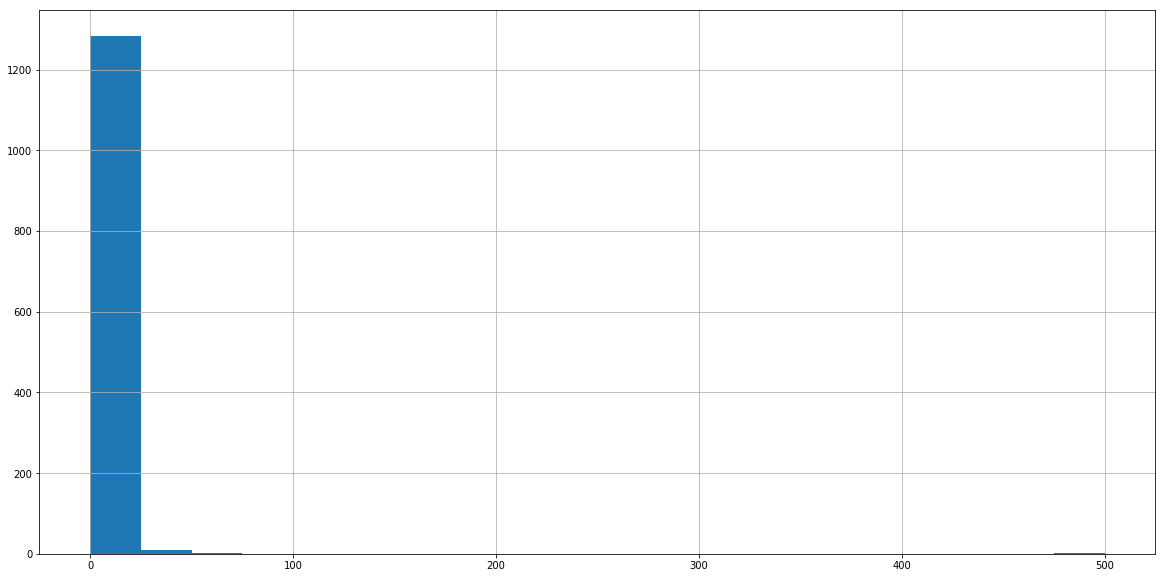

In [64]:
f3.hist(bins=20,figsize=(20,10)) #값이 50정도만 넘어가도 이상치로 보인다

In [65]:
f3.loc[f3>=20] #20정도만 넘어가는 값들이 약 20개가 존재한다.

0        26.315789
62       33.333333
123      22.727273
211      41.666667
654      24.390244
716      33.333333
818      26.315789
895      25.641026
898      20.304569
921      21.739130
936      23.809524
942     500.000000
977      66.666667
1009     45.454545
1071     45.454545
1197     27.777778
1207     55.555556
1216     22.727273
dtype: float64

In [66]:
for i in range(0,len(f3)):
    if f3[i]>=20:
        f3[i]=20 #20이상인 값들을 20으로 통일
    else:
        pass

In [67]:
f4.describe() #f2와 동일한 모습을 보인다

count    1267.000000
mean             inf
std              NaN
min       -27.500000
25%         4.875575
50%         6.790541
75%         9.038462
max              inf
dtype: float64

In [68]:
f4.loc[f4>=100] #최대값 찾는 과정

132            inf
153            inf
180            inf
277            inf
435            inf
563            inf
621     107.500000
622            inf
637            inf
650            inf
679            inf
774     110.000000
775     197.500000
830            inf
915            inf
1070    172.500000
1083           inf
1111           inf
1240           inf
1258           inf
dtype: float64

In [69]:
for i in range(0,len(f4)):
    if f4[i]==math.inf:
        f4[i]=197.500000 #inf를 최대값으로 대체
    else:
        pass

In [70]:
f4.loc[f4>=50] #inf를 제외하고 50을 넘어가는 값들이 거의 없다.

23       64.166667
132     197.500000
153     197.500000
180     197.500000
277     197.500000
282      72.500000
434      85.000000
435     197.500000
563     197.500000
621     107.500000
622     197.500000
623      50.000000
637     197.500000
650     197.500000
652      72.500000
679     197.500000
774     110.000000
775     197.500000
821      97.500000
830     197.500000
915     197.500000
1070    172.500000
1071     97.500000
1083    197.500000
1111    197.500000
1240    197.500000
1258    197.500000
dtype: float64

In [71]:
for i in range(0,len(f4)):
    if f4[i]>=50:
        f4[i]=50 #50이상인 값들을 50으로 통일
    else:
        pass

In [72]:
f5.describe() #f3과는 반대로 마이너스 값이 이상치로 보인다

count    1295.000000
mean        4.572950
std         9.551493
min      -189.000000
25%         2.916469
50%         5.814815
75%         8.525263
max        11.000000
dtype: float64

C:\Users\bluedice\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


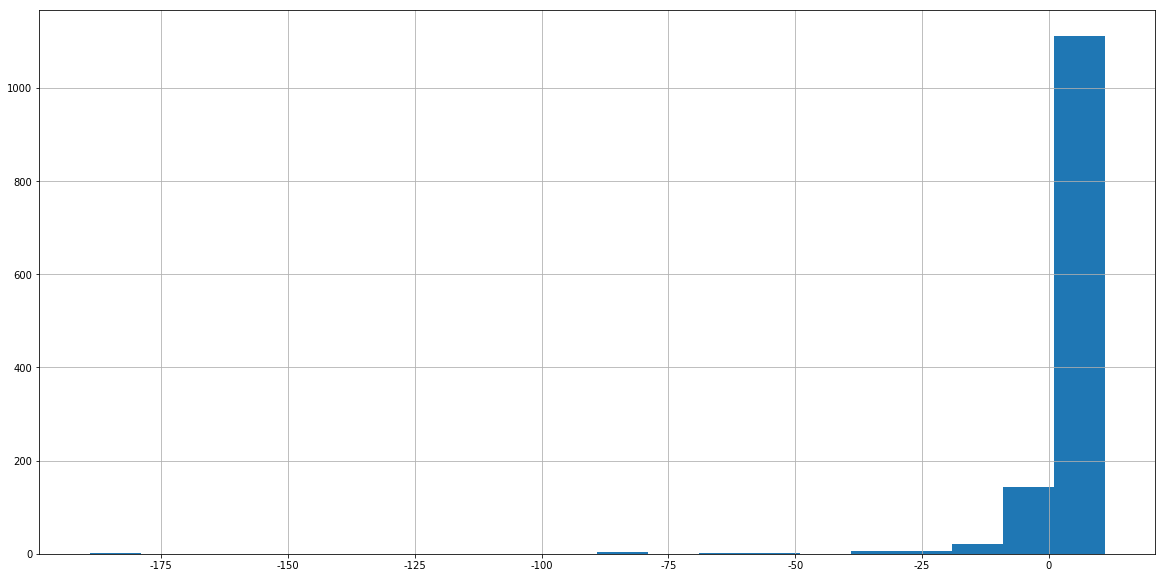

In [73]:
f5.hist(bins=20,figsize=(20,10)) #값이 -25 정도만 넘어가도 이상치로 보인다

In [74]:
for i in range(0,len(f5)):
    if f5[i]<=-25:
        f5[i]=-25 #-25 이하인 값들을 -25로 통일
    else:
        pass

In [75]:
#각 값들은 0~10사이의 값을 가져야 되므로 값 최적화 과정을 해줌

f1=((f1-f1.min())/(f1.max()-f1.min()))*10

f2=((f2-f2.min())/(f2.max()-f2.min()))*10

f3=((f3-f3.min())/(f3.max()-f3.min()))*10

f4=((f4-f4.min())/(f4.max()-f4.min()))*10

f5=((f5-f5.min())/(f5.max()-f5.min()))*10

regular3['SPD']=(f1+f2+f3+f4+f5)/5

regular3['SPD']=regular3['SPD'].fillna(0) #값이 빈 경우는 0으로 대체

wOBA구하기

In [76]:
#변화되는 공식이 아닌 일반적인 공식을 사용하였음
regular3['wOBA']=(0.72*regular3['BB'] + 0.75*regular3['HBP'] + 0.9*regular3['1B'] + 1.24*regular3['2B'] + 1.56*regular3['3B'] + 1.95*regular3['HR'] ) / ( regular3['AB'] +regular3['FBP'] + regular3['fly'] )
regular3['wOBA']=regular3['wOBA'].fillna(0.0) 

regular3['wOBA']=round(regular3['wOBA'],3)

C:\Users\bluedice\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


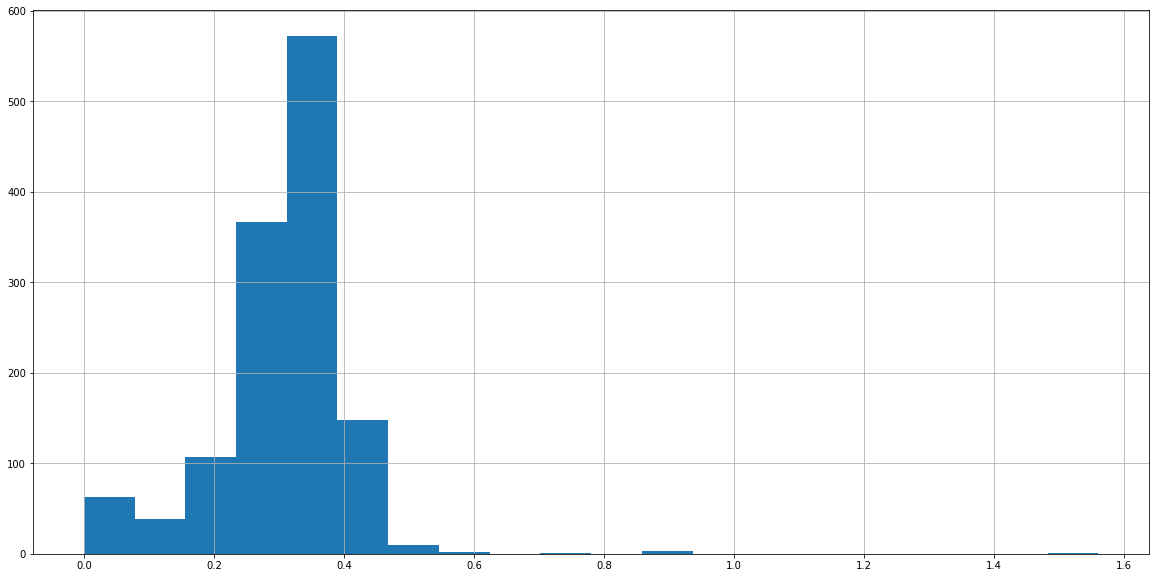

In [77]:
regular3['wOBA'].hist(bins=20,figsize=(20,10)) #확인 필요

OPS+구하기

In [78]:
#각 시즌별 평균 값이 필요하기 때문에 해당 과정을 실시
mra=regular3.groupby(['year'])['wOBA', 'R','H','FBP', 'AB', 'fly', 'TB'].sum()
mra2=regular3.groupby(['year'])['wOBA', 'R','H','FBP', 'AB', 'fly', 'TB'].size()
mra['size']=mra2

mra.to_csv("C:\\Users\\bluedice\\Desktop\\mra.csv")
mra=pd.read_csv(r"C:\Users\bluedice\Desktop\mra.csv")

In [79]:
mra #현재 2000년대 연도들은 사이즈가 너무 작아서 평균을 구하는게 힘들어 보임
#그래서 몇개 연도를 합쳐서 그 평균값을 사용하기로 결정함(2004년이전, 2005~2006 통합)

,year,wOBA,R,H,FBP,AB,fly,TB,size
0,2001,1.628,136,215,121,718,0.0,368,4
1,2002,1.956,212,401,181,1478,9.0,604,7
2,2003,4.219,367,691,309,2507,16.0,1041,14
3,2004,6.064,484,902,435,3466,37.0,1417,20
4,2005,6.634,723,1336,616,5099,38.0,1989,23
5,2006,9.221,851,1707,712,6257,43.0,2458,29
6,2007,9.978,1078,2100,891,7730,59.0,3000,35
7,2008,12.999,1513,2864,1295,10243,96.0,4141,46
8,2009,17.667,2098,3592,1698,12874,123.0,5651,58
9,2010,18.256,2426,4310,2046,15509,137.0,6566,59


In [80]:
#2004년 이전 합치기
k= (mra.loc[mra['year']<=2004,'wOBA'].sum()) 
mra.loc[mra['year']<=2004,'wOBA']=k

k= (mra.loc[mra['year']<=2004,'R'].sum()) 
mra.loc[mra['year']<=2004,'R']=k

k= (mra.loc[mra['year']<=2004,'H'].sum()) 
mra.loc[mra['year']<=2004,'H']=k

k= (mra.loc[mra['year']<=2004,'FBP'].sum()) 
mra.loc[mra['year']<=2004,'FBP']=k

k= (mra.loc[mra['year']<=2004,'AB'].sum()) 
mra.loc[mra['year']<=2004,'AB']=k

k= (mra.loc[mra['year']<=2004,'fly'].sum()) 
mra.loc[mra['year']<=2004,'fly']=k

k= (mra.loc[mra['year']<=2004,'TB'].sum()) 
mra.loc[mra['year']<=2004,'TB']=k

k= (mra.loc[mra['year']<=2004,'size'].sum()) 
mra.loc[mra['year']<=2004,'size']=k

#2005년과 2006년 합치기

k= (mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'wOBA'].sum()) 
mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'wOBA']=k

k= (mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'R'].sum()) 
mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'R']=k

k= (mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'H'].sum()) 
mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'H']=k

k= (mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'FBP'].sum()) 
mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'FBP']=k

k= (mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'AB'].sum()) 
mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'AB']=k

k= (mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'fly'].sum()) 
mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'fly']=k

k= (mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'TB'].sum()) 
mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'TB']=k

k= (mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'size'].sum()) 
mra.loc[(mra['year']<=2006) & (mra['year']>=2005) ,'size']=k

In [81]:
mra['aOBP']=(mra['H']+mra['FBP'])/(mra['AB']+mra['FBP']+mra['fly']) #각 연도의 평균 OBP생성

mra['aSLG']=mra['TB']/mra['AB'] #각 연도의 평균 SLG생성

mra_total=mra[['year','aOBP','aSLG']] #각 연도별 평균 OBP,SLG만 추출

In [82]:
regular3.to_csv("C:\\Users\\bluedice\\Desktop\\regular3.csv")

In [83]:
regular4=pd.merge(regular3,mra_total,how='left') #각 선수별 OPS+를 적용시키기 위해서 통합 실시

In [84]:
#OPS + 를 구하는 공식을 사용하고 OPS+는 자연수 값이기 때문에 반올림로 정수 처리하였음
regular4['OPS+']= ( (regular4['OBP']/regular4['aOBP']) + (regular4['SLG']/regular4['aSLG']) -1 ) * 100
regular4['OPS+']=round(regular4['OPS+'],0)

C:\Users\bluedice\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


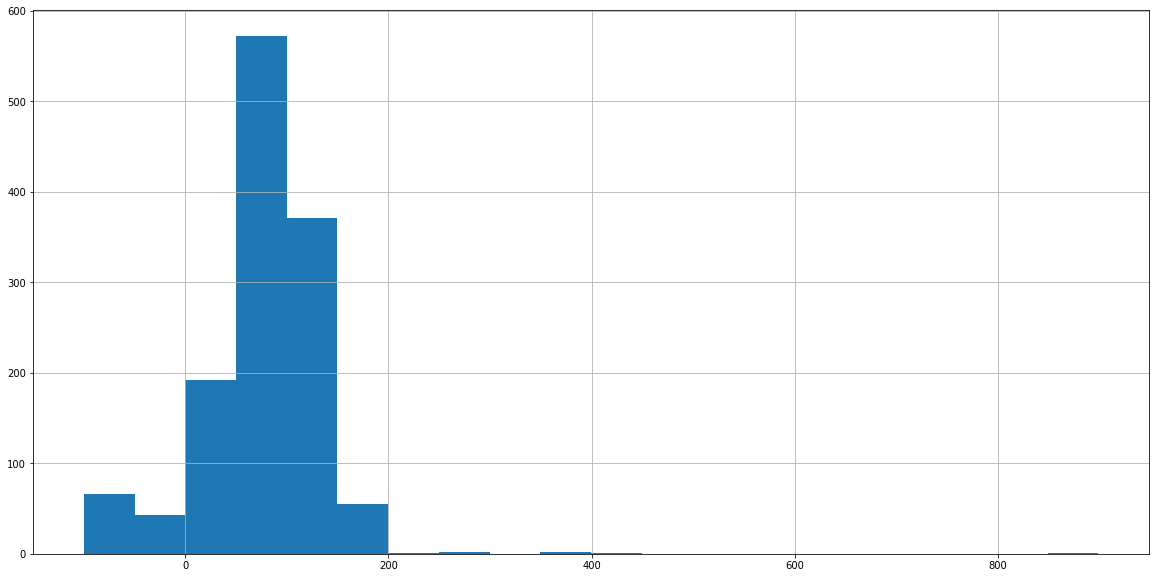

In [85]:
regular4['OPS+'].hist(bins=20,figsize=(20,10)) #현재 0이하의 값과 200이상의 이상치들이 보이는 모습이 있음

In [86]:
regular4.loc[regular4['OPS+']>=200,['OPS+']]=200 #200이상의 이상치는 200으로 처리
regular4.loc[regular4['OPS+']<=0,['OPS+']]=0 #0이하의 값은 0으로 처리

#다 사용이 된 평균 OBP,SLG는 삭제함
del regular4['aOBP']
del regular4['aSLG']

C:\Users\bluedice\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


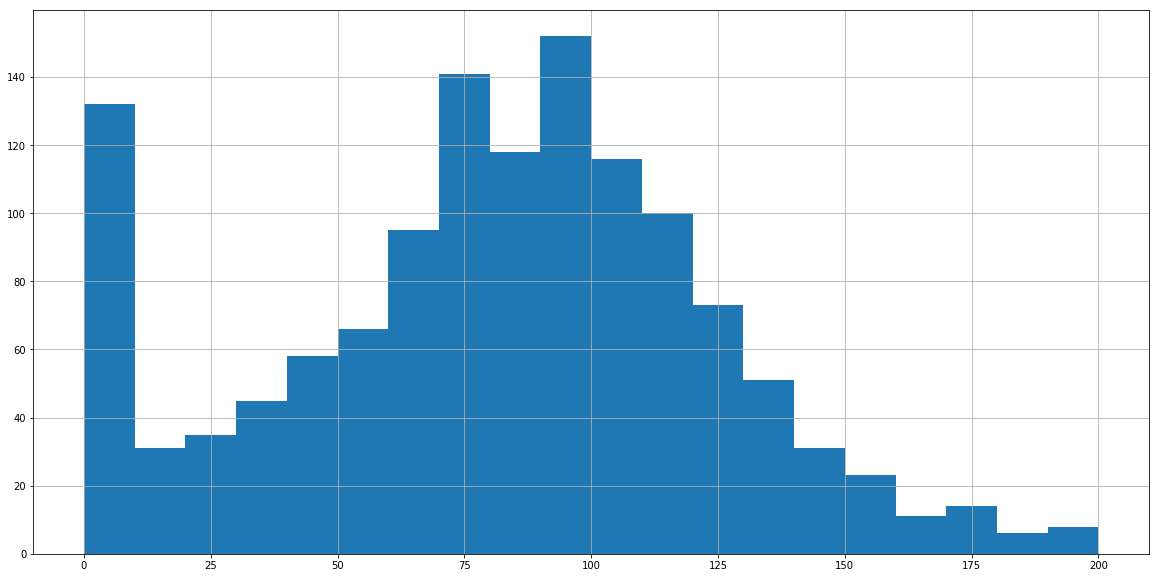

In [87]:
regular4['OPS+'].hist(bins=20,figsize=(20,10)) #이상치 제거 이후 OPS+확인 작업

10. 나이 결측치 해결하기

현재 데이터에서는 스탯티즈에서 빈 값들로 인해 나이가 비어있는 observation들이 존재한다.
이 결측치를 채우기 위해 year_born을 이용하려 한다.

In [88]:
#마지막 부분을 제외하고는 2017년도까지의 선수들 중에서 스탯티즈에 기록이 없는 선수들이다.
#마지막 부분의 경우는 
regular4.loc[regular4.isnull()['age'],['batter_name','year_born','year','age','YOPS']]

,batter_name,year_born,year,age,YOPS
4,강구성,1993년 06월 09일,2015,NaN,0.000
5,강구성,1993년 06월 09일,2016,NaN,0.000
6,강구성,1993년 06월 09일,2017,NaN,0.600
246,나주환,1984년 06월 14일,2003,NaN,0.912
247,나주환,1984년 06월 14일,2004,NaN,0.594
248,나주환,1984년 06월 14일,2005,NaN,0.654
249,나주환,1984년 06월 14일,2006,NaN,0.600
250,나주환,1984년 06월 14일,2007,NaN,0.696
251,나주환,1984년 06월 14일,2008,NaN,0.764
252,나주환,1984년 06월 14일,2009,NaN,0.804


In [89]:
#해당 결측치를 보유한 선수들의 나이를 해당시즌과 생년월일을 이용하여서 구해줌

regular4.loc[regular4['batter_name']=='강구성','age']=regular4['year']-int(regular4['year_born'][4].split('년')[0])
regular4.loc[regular4['batter_name']=='나주환','age']=regular4['year']-int(regular4['year_born'][245].split('년')[0])
regular4.loc[regular4['batter_name']=='이대형','age']=regular4['year']-int(regular4['year_born'][652].split('년')[0])
regular4.loc[regular4['batter_name']=='김철호','age']=regular4['year']-int(regular4['year_born'][1128].split('년')[0])

#year_born 같은 경우는 나이로 대체가 가능하므로 제거하였음
del regular4['year_born']

In [90]:
regular4.describe()

,batter_id,year,G,AB,H,2B,3B,HR,TB,SB,CS,BB,HBP,R,RBI,E,SO,GDP,avg,OBP,SLG,OPS,p_year,YAB,YOPS,height,weight,1B,run,FBP,eqa,isop,1b_luck,2b_luck,3b_luck,salary,war,age,PA,GB,BU,fly,BB%,SO%,babip,SPD,wOBA,OPS+
count,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1305.000000,1306.000000,1312.000000,1305.000000,1312.000000,1085.000000,1069.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1305.000000,1295.000000,1295.000000,1295.000000,1312.000000,1312.000000,1312.000000,1312.000000,1279.000000,1312.000000,1312.000000,1312.000000,1306.000000,1312.000000,1312.000000,1312.000000,1306.000000
mean,169.817073,2013.541921,79.434451,229.286585,64.964177,11.464177,1.132622,6.445884,98.031250,6.019055,2.603659,23.397866,4.085366,35.172256,32.320884,4.179116,44.861280,5.114329,0.251201,0.319606,0.367418,0.688473,2014.541921,155.606452,0.691438,181.568598,86.824695,45.921494,8.622713,27.483232,0.718723,0.118188,0.241613,0.059346,0.006198,14666.116616,1.286366,26.434451,262.214177,0.840500,3.363567,2.069360,0.078043,0.206377,0.300114,3.784943,0.305878,80.096478
std,95.388123,4.051131,44.756911,174.497815,54.579184,10.329297,1.853301,8.439318,86.203703,9.518400,3.349909,21.551038,4.555316,30.168546,31.035399,4.733872,33.806317,4.776536,0.092552,0.103874,0.162308,0.249992,4.051131,108.488121,0.232600,4.661365,10.860382,38.576965,12.367320,24.618859,0.246218,0.094648,0.094771,0.047422,0.029501,24231.748536,1.855739,4.523552,200.198221,1.810563,4.265554,2.380106,0.050456,0.112054,0.108852,1.267566,0.106804,43.456235
min,0.000000,2001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2002.000000,0.000000,0.000000,165.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1800.000000,-1.616000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,86.000000,2011.000000,38.000000,56.750000,12.000000,2.000000,0.000000,0.000000,17.000000,0.000000,0.000000,4.000000,0.000000,8.000000,5.000000,1.000000,15.000000,1.000000,0.221000,0.289000,0.297000,0.596000,2012.000000,49.000000,0.605000,178.000000,79.000000,9.000000,1.000000,5.000000,0.635000,0.063000,0.214286,0.038278,0.000000,2900.000000,-0.059000,23.000000,64.750000,0.000000,0.000000,0.000000,0.055000,0.138650,0.275000,3.190949,0.270000,53.000000
50%,169.000000,2015.000000,90.000000,211.000000,55.000000,9.000000,0.000000,3.000000,78.500000,2.000000,1.000000,18.000000,3.000000,29.000000,24.000000,3.000000,42.500000,4.000000,0.265000,0.335000,0.378500,0.719000,2016.000000,158.000000,0.724000,182.000000,85.000000,40.000000,4.000000,22.000000,0.755000,0.112000,0.250000,0.059006,0.000000,5600.000000,0.474500,26.000000,238.000000,0.000000,2.000000,1.000000,0.080000,0.188081,0.315000,3.784021,0.322000,84.000000
75%,251.000000,2017.000000,120.000000,393.250000,113.000000,19.000000,2.000000,9.250000,166.000000,7.000000,4.000000,39.000000,6.000000,58.000000,53.000000,6.000000,69.000000,8.000000,0.300000,0.372750,0.452000,0.820000,2018.000000,256.000000,0.833000,185.000000,94.000000,78.000000,11.000000,45.000000,0.846000,0.166000,0.279863,0.076923,0.007772,15000.000000,2.352250,29.000000,450.250000,1.000000,5.000000,3.000000,0.102000,0.250000,0.348000,4.521318,0.361000,108.000000
max,344.000000,2018.000000,144.000000,600.000000,201.000000,47.000000,17.000000,52.000000,346.000000,66.000000,21.000000,108.000000,27.000000,135.000000,144.000000,27.000000,146.000000,24.000000,1.000000,1.000000,3.000000,4.000000,2019.000000,410.000000,1.750000,194.000000,130.000000,174.000000,87.000000,117.000000,4.000000,2.000000,1.000000,1.000000,1.000000,250000.000000,8.825000,39.000000,672.000000,25.000000,25.000000,13.0

In [91]:
regular4.head(3)

,batter_id,batter_name,year,team,position,G,AB,H,2B,3B,HR,TB,SB,CS,BB,HBP,R,RBI,E,SO,GDP,avg,OBP,SLG,OPS,career,starting_salary,p_year,YAB,YOPS,height,weight,1B,run,FBP,eqa,isop,1b_luck,2b_luck,3b_luck,hand,salary,war,age,PA,GB,BU,fly,BB%,SO%,babip,SPD,wOBA,OPS+
0,1,강경학,2014,한화,내야수,41,86,19,2,3,1,30,0,0,13,2,11,7,6,28,1,0.221,0.337,0.349,0.686,광주대성초-광주동성중-광주동성고,10000만원,2015,156.0,0.679,180,72,13,0,15,0.708,0.128,0.228070,0.035088,0.052632,좌타,2400,0.053,22.0,103.0,0.0,2.0,0.0,0.126,0.271845,0.316,5.213515,0.314,69.0
1,1,강경학,2015,한화,내야수,120,311,80,7,4,2,101,4,3,40,5,50,27,15,58,3,0.257,0.348,0.325,0.673,광주대성초-광주동성중-광주동성고,10000만원,2016,81.0,0.447,180,72,67,7,45,0.707,0.068,0.266932,0.027888,0.015936,좌타,6500,0.010,23.0,376.0,1.0,18.0,3.0,0.106,0.154255,0.307,4.607615,0.311,72.0
2,1,강경학,2016,한화,내야수,46,101,16,3,2,1,26,0,0,8,2,16,7,7,30,5,0.158,0.232,0.257,0.489,광주대성초-광주동성중-광주동성고,10000만원,2017,82.0,0.542,180,72,10,0,10,0.514,0.099,0.142857,0.042857,0.028571,좌타,6500,-0.943,24.0,116.0,0.0,4.0,1.0,0.069,0.258621,0.211,4.281728,0.224,20.0


In [92]:
#변수들끼리 모아두기 위해서 column 위치를 수정해줌
col=['batter_id', 'batter_name', 'year', 'team', 'age', 'height', 'weight', 'position', 'hand',
 'G', 'PA','AB', 'H', '1B','2B', '3B','HR', 'TB', 'SB', 'CS', 'run', 'BB', 'HBP','GB','FBP','BB%',
'R','RBI', 'E', 'SO', 'GDP','SO%','BU','fly', 'avg', 'OBP','SLG','OPS', 'war','babip', 'eqa', 'isop','SPD','wOBA','OPS+',
'1b_luck','2b_luck','3b_luck','salary','career', 'p_year','starting_salary','YAB','YOPS']

regular5=DataFrame(regular4,columns=col)

In [93]:
regular5.to_csv('C:\\Users\\bluedice\\Desktop\\total_form.csv', sep=',',  na_rep='NaN')

In [94]:
regular5.head()

,batter_id,batter_name,year,team,age,height,weight,position,hand,G,PA,AB,H,1B,2B,3B,HR,TB,SB,CS,run,BB,HBP,GB,FBP,BB%,R,RBI,E,SO,GDP,SO%,BU,fly,avg,OBP,SLG,OPS,war,babip,eqa,isop,SPD,wOBA,OPS+,1b_luck,2b_luck,3b_luck,salary,career,p_year,starting_salary,YAB,YOPS
0,1,강경학,2014,한화,22.0,180,72,내야수,좌타,41,103.0,86,19,13,2,3,1,30,0,0,0,13,2,0.0,15,0.126,11,7,6,28,1,0.271845,2.0,0.0,0.221,0.337,0.349,0.686,0.053,0.316,0.708,0.128,5.213515,0.314,69.0,0.228070,0.035088,0.052632,2400,광주대성초-광주동성중-광주동성고,2015,10000만원,156.0,0.679
1,1,강경학,2015,한화,23.0,180,72,내야수,좌타,120,376.0,311,80,67,7,4,2,101,4,3,7,40,5,1.0,45,0.106,50,27,15,58,3,0.154255,18.0,3.0,0.257,0.348,0.325,0.673,0.010,0.307,0.707,0.068,4.607615,0.311,72.0,0.266932,0.027888,0.015936,6500,광주대성초-광주동성중-광주동성고,2016,10000만원,81.0,0.447
2,1,강경학,2016,한화,24.0,180,72,내야수,좌타,46,116.0,101,16,10,3,2,1,26,0,0,0,8,2,0.0,10,0.069,16,7,7,30,5,0.258621,4.0,1.0,0.158,0.232,0.257,0.489,-0.943,0.211,0.514,0.099,4.281728,0.224,20.0,0.142857,0.042857,0.028571,6500,광주대성초-광주동성중-광주동성고,2017,10000만원,82.0,0.542
3,1,강경학,2017,한화,25.0,180,72,내야수,좌타,59,93.0,84,18,15,2,1,0,22,1,1,2,8,1,0.0,9,0.086,17,4,4,19,1,0.204301,0.0,0.0,0.214,0.290,0.262,0.552,-0.441,0.277,0.586,0.048,4.550227,0.259,40.0,0.230769,0.030769,0.015385,6200,광주대성초-광주동성중-광주동성고,2018,10000만원,115.0,0.921
4,2,강구성,2015,NC,22.0,180,82,외야수,좌타,4,8.0,5,1,0,1,0,0,2,0,0,0,0,0,NaN,0,0.000,0,0,0,0,0,0.000000,3.0,0.0,0.200,0.200,0.400,0.600,-0.020,0.200,0.600,0.200,0.000000,0.248,48.0,0.000000,0.200000,0.000000,2700,관산초-부천중-야탑고-NC-상무,2016,9000만원,2.0,0.000


In [125]:
regular5.describe()

,batter_id,year,age,height,weight,G,PA,AB,H,1B,2B,3B,HR,TB,SB,CS,run,BB,HBP,GB,FBP,BB%,R,RBI,E,SO,GDP,SO%,BU,fly,avg,OBP,SLG,OPS,war,babip,eqa,isop,SPD,wOBA,OPS+,1b_luck,2b_luck,3b_luck,salary,p_year,YAB,YOPS
count,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1273.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1306.000000,1312.000000,1312.000000,1305.000000,1306.000000,1312.000000,1305.000000,1312.000000,1312.000000,1312.000000,1305.000000,1312.000000,1312.000000,1306.000000,1295.000000,1295.000000,1295.000000,1312.000000,1312.000000,1085.000000,1069.000000
mean,169.817073,2013.541921,26.597561,181.568598,86.824695,79.434451,262.260671,229.286585,64.964177,45.921494,11.464177,1.132622,6.445884,98.031250,6.019055,2.603659,8.622713,23.397866,4.085366,0.839749,27.483232,0.077996,35.172256,32.320884,4.179116,44.861280,5.114329,0.206311,3.409299,2.070122,0.251201,0.319606,0.367418,0.688473,1.286366,0.300114,0.718723,0.118188,3.784943,0.305878,80.096478,0.241613,0.059346,0.006198,14666.116616,2014.541921,155.606452,0.691438
std,95.388123,4.051131,4.291577,4.661365,10.860382,44.756911,200.211640,174.497815,54.579184,38.576965,10.329297,1.853301,8.439318,86.203703,9.518400,3.349909,12.367320,21.551038,4.555316,1.813495,24.618859,0.050414,30.168546,31.035399,4.733872,33.806317,4.776536,0.112062,4.323424,2.381525,0.092552,0.103874,0.162308,0.249992,1.855739,0.108853,0.246218,0.094648,1.267566,0.106804,43.456235,0.094771,0.047422,0.029501,24231.748536,4.051131,108.488121,0.232600
min,0.000000,2001.000000,18.000000,165.000000,64.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.616000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1800.000000,2002.000000,0.000000,0.000000
25%,86.000000,2011.000000,23.000000,178.000000,79.000000,38.000000,64.000000,56.750000,12.000000,9.000000,2.000000,0.000000,0.000000,17.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,5.000000,0.055000,8.000000,5.000000,1.000000,15.000000,1.000000,0.139285,0.000000,0.000000,0.221000,0.289000,0.297000,0.596000,-0.059000,0.275000,0.635000,0.063000,3.190949,0.270000,53.000000,0.214286,0.038278,0.000000,2900.000000,2012.000000,49.000000,0.605000
50%,169.000000,2015.000000,26.000000,182.000000,85.000000,90.000000,238.000000,211.000000,55.000000,40.000000,9.000000,0.000000,3.000000,78.500000,2.000000,1.000000,4.000000,18.000000,3.000000,0.000000,22.000000,0.080000,29.000000,24.000000,3.000000,42.500000,4.000000,0.188144,2.000000,1.000000,0.265000,0.335000,0.378500,0.719000,0.474500,0.315000,0.755000,0.112000,3.784021,0.322000,84.000000,0.250000,0.059006,0.000000,5600.000000,2016.000000,158.000000,0.724000
75%,251.000000,2017.000000,29.000000,185.000000,94.000000,120.000000,452.000000,393.250000,113.000000,78.000000,19.000000,2.000000,9.250000,166.000000,7.000000,4.000000,11.000000,39.000000,6.000000,1.000000,45.000000,0.102000,58.000000,53.000000,6.000000,69.000000,8.000000,0.250000,5.000000,3.000000,0.300000,0.372750,0.452000,0.820000,2.352250,0.348000,0.846000,0.166000,4.521318,0.361000,108.000000,0.279863,0.076923,0.007772,15000.000000,2018.000000,256.000000,0.833000
max,344.000000,2018.000000,39.000000,194.000000,130.000000,144.000000,672.000000,600.000000,201.000000,174.000000,47.000000,17.000000,52.000000,346.000000,66.000000,21.000000,87.000000,108.000000,27.000000,25.000000,117.000000,1.000000,135.000000,144.000000,27.000000,146.000000,24.000000,1.000000,25.000000,13.000000,1.000000,1.000000,3.000000,4.000000,8.825000,1.000000,4.000000,2.000000,7.439360,1.560000,200.000000,1.000000,1

현재 결측치 존재 : GB, FBP% SO%, GDP% avg obp, ops ops+ lb_luck~tb_luck, YOPS-> 16개

1X. 모델링 과정

xgb regressor

In [28]:
from xgboost import XGBRegressor

In [ ]:
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

del regular5['Unnamed: 0']

del regular5['batter_id']
del regular5['starting_salary']
del regular5['career']
del regular5['p_year']


regular5=regular5[ regular5.columns[regular5.columns!='position'] ]
regular5=regular5[ regular5.columns[regular5.columns!='batter_name'] ]
regular5=regular5[ regular5.columns[regular5.columns!='team'] ]
regular5=regular5[ regular5.columns[regular5.columns!='hand'] ]

train2=regular5.loc[regular5['year']<=2017,]
train2=train2.fillna(0.0)

test2=regular5.loc[(regular5['year']==2018),]
test2=test2.fillna(0.0)

y_train=train2[['YOPS','YAB']]
y_test=test2[['YOPS','YAB']]

X_train=train2[ train2.columns[train2.columns!='YOPS'] ]
X_train=X_train[ X_train.columns[X_train.columns!='YAB'] ]
X_test=test2[ test2.columns[test2.columns!='YOPS'] ]
X_test=X_test[ X_test.columns[X_test.columns!='YAB'] ]

del X_train['year']
del X_test['year']

In [ ]:
i1=[]
i2=[]
i3=[]
i4=[]
i5=[]
for i in (0.0025,0.005,0.01,0.02,0.025):
    for j in (90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250):
        for k in (0.4,0.45,0.5,0.55,0.6):
            for y in (1,2,4,5):
                i1.append(i)
                i2.append(j)
                i3.append(k)
                i4.append(y)
                est=XGBRegressor(max_depth=3, learning_rate=i, n_estimators=100,
                         objective='reg:linear', booster='gblinear', reg_lambda=y,
                         scale_pos_weight=j, base_score=k, random_state=0,
                         seed=None, missing=None)
                result=est.fit(X_train, y_train['YOPS'], sample_weight=None, eval_set=None, eval_metric=None,
                      early_stopping_rounds=None, verbose=True, xgb_model=None)
            
                y_pred=est.predict(X_train)
                i5.append( ( (((y_train['YOPS']-y_pred)**2)*y_train['YAB']).sum() )  /  y_train['YAB'].sum() )
            
i1=DataFrame(i1,columns=['lr'])
i2=DataFrame(i2,columns=['sp'])
i3=DataFrame(i3,columns=['bs'])
i4=DataFrame(i4,columns=['lambda'])
i5=DataFrame(i5,columns=['wr'])

to=pd.concat([i1,i2,i3,i4,i5],axis=1)

to.loc[to['wr']==to['wr'].min(),]

이렇게 나온 값들은 이후 test set을 할 때 그대로 투입할 예정이다.

2017 train 기준 0.005 190 0.4 1

2016 train 기준 0.01 150 0.45 5

2015 train 기준 0.005 240 0.4 4

2014 train 기준 0.01 220 0.45 5

2013 train 기준 0.01 190 0.45 5

In [ ]:
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

del regular5['Unnamed: 0']

del regular5['batter_id']
del regular5['starting_salary']
del regular5['career']
del regular5['p_year']

regular6=regular5[ regular5.columns[regular5.columns!='position'] ]
regular6=regular6[ regular6.columns[regular6.columns!='batter_name'] ]
regular6=regular6[ regular6.columns[regular6.columns!='team'] ]
regular6=regular6[ regular6.columns[regular6.columns!='hand'] ]

In [ ]:
k1=[0.014429]
k2=[]
k3=[]

for i in range(43,0,-1):
    regular7=regular6[ regular6.columns[regular6.columns!=regular6.columns[i]] ]
    
    train2=regular7.loc[regular7['year']<=2016,]
    train2=train2.fillna(0.0)

    test2=regular7.loc[(regular7['year']==2017),]
    test2=test2.fillna(0.0)

    y_train=train2[['YOPS','YAB']]
    y_test=test2[['YOPS','YAB']]

    X_train=train2[ train2.columns[train2.columns!='YOPS'] ]
    X_train=X_train[ X_train.columns[X_train.columns!='YAB'] ]
    X_test=test2[ test2.columns[test2.columns!='YOPS'] ]
    X_test=X_test[ X_test.columns[X_test.columns!='YAB'] ]

    del X_train['year']
    del X_test['year']

    est=XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=100,
                         objective='reg:linear', booster='gblinear', reg_lambda=5,
                         scale_pos_weight=150, base_score=0.45, random_state=0,
                         seed=None, missing=None)

    result=est.fit(X_train, y_train['YOPS'], sample_weight=None, eval_set=None, eval_metric=None,
                      early_stopping_rounds=None, verbose=True, xgb_model=None)

    y_pred=est.predict(X_train)

    k2.append( ( (((y_train['YOPS']-y_pred)**2)*y_train['YAB']).sum() )  /  y_train['YAB'].sum() )
    
    if k1>k2:
        k1=k2
        k2=[]
        del regular6[regular6.columns[i]]
    else:
        k2=[]
        k3.append( regular6.columns[i] )

In [ ]:
k3

17 train 기준 'salary','3b_luck','2b_luck','1b_luck','war','BU','SO%','E','RBI','FBP','HBP','BB','CS','SB','TB','HR','weight','height',

2016 train 기준 'salary','war','BU','SO%','E','RBI','FBP','HBP','BB','CS','SB','TB','HR','weight','height',

15 train 기준 'salary','war','BU','SO%','E','RBI','FBP','HBP','BB','run','CS','SB','TB','HR','3B','2B','weight','height','age',

14 train 기준 'salary','2b_luck','babip','war','OBP','avg','fly','BU','SO%','E','RBI','FBP','HBP','BB','run','CS','SB','HR','3B','weight','age',

13 train 기준 '3b_luck','babip','war','OBP','avg','fly','BU','SO%','E','RBI','FBP','HBP','BB','run','CS','SB','HR','3B','weight','age',

각 연도마다 train의 wrmse를 최소로 가지게 하는 변수들이 달랐기 때문에 많은 빈도수를 가진 변수들로만 추리는게 모델을 간단화 하는데 좋다고 판단되었고 추려낸 변수들은 다음과 같다.

예상 변수 'salary','war','BU','SO%','E','RBI','FBP','HBP','BB','CS','SB','HR','weight','run','3B','age','TB','height','babip','OBP','avg','fly',

In [ ]:
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

del regular5['Unnamed: 0']

del regular5['batter_id']
del regular5['starting_salary']
del regular5['career']
del regular5['p_year']

regular6=regular5[ regular5.columns[regular5.columns!='position'] ]
regular6=regular6[ regular6.columns[regular6.columns!='batter_name'] ]
regular6=regular6[ regular6.columns[regular6.columns!='team'] ]
regular6=regular6[ regular6.columns[regular6.columns!='hand'] ]

regular6=regular6[['year','salary','war','BU','SO%','E','RBI','FBP','HBP','BB','CS','SB','HR','weight','run','3B','age','TB','height','babip','OBP','avg','fly',
                'YOPS','YAB']]

train2=regular6.loc[regular6['year']<=2016,]
train2=train2.fillna(0.0)

test2=regular6.loc[(regular6['year']==2017),]
test2=test2.fillna(0.0)

y_train=train2[['YOPS','YAB']]
y_test=test2[['YOPS','YAB']]

X_train=train2[ train2.columns[train2.columns!='YOPS'] ]
X_train=X_train[ X_train.columns[X_train.columns!='YAB'] ]
X_test=test2[ test2.columns[test2.columns!='YOPS'] ]
X_test=X_test[ X_test.columns[X_test.columns!='YAB'] ]

del X_train['year']
del X_test['year']

In [ ]:
est=XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=100,
                     objective='reg:linear', booster='gblinear', reg_lambda=5,
                     scale_pos_weight=150, base_score=0.45, random_state=0,
                     seed=None, missing=None)

result=est.fit(X_train, y_train['YOPS'], sample_weight=None, eval_set=None, eval_metric=None,
                  early_stopping_rounds=None, verbose=True, xgb_model=None)

y_pred=est.predict(X_test)

( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()

In [ ]:
#팀 변수 확인
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

del regular5['Unnamed: 0']

del regular5['batter_id']
del regular5['starting_salary']
del regular5['career']
del regular5['p_year']

regular5=regular5[ regular5.columns[regular5.columns!='position'] ]
regular5=regular5[ regular5.columns[regular5.columns!='batter_name'] ]
regular5=regular5[ regular5.columns[regular5.columns!='hand'] ]

p1=pd.get_dummies(regular5['team'])

regular6=regular5[['year','salary','war','BU','SO%','E','RBI','FBP','HBP','BB','CS','SB','HR','weight','run','3B','age','TB','height','babip','OBP','avg','fly',
                'YOPS','YAB']]

regular6=pd.concat([regular6,p1],axis=1)

regular6=regular6.reset_index(drop=True)

train2=regular6.loc[regular6['year']<=2016,]
train2=train2.fillna(0.0)

test2=regular6.loc[(regular6['year']==2017),]
test2=test2.fillna(0.0)

y_train=train2[['YOPS','YAB']]
y_test=test2[['YOPS','YAB']]

X_train=train2[ train2.columns[train2.columns!='YOPS'] ]
X_train=X_train[ X_train.columns[X_train.columns!='YAB'] ]
X_test=test2[ test2.columns[test2.columns!='YOPS'] ]
X_test=X_test[ X_test.columns[X_test.columns!='YAB'] ]

del X_train['year']
del X_test['year']

In [ ]:
est=XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=100,
                     objective='reg:linear', booster='gblinear', reg_lambda=5,
                     scale_pos_weight=150, base_score=0.45, random_state=0,
                     seed=None, missing=None)

result=est.fit(X_train, y_train['YOPS'], sample_weight=None, eval_set=None, eval_metric=None,
                  early_stopping_rounds=None, verbose=True, xgb_model=None)

y_pred=est.predict(X_test)

( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()

In [ ]:
#타석 위치 변수 확인
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

del regular5['Unnamed: 0']

del regular5['batter_id']
del regular5['starting_salary']
del regular5['career']
del regular5['p_year']

regular5=regular5[ regular5.columns[regular5.columns!='position'] ]
regular5=regular5[ regular5.columns[regular5.columns!='batter_name'] ]

p1=pd.get_dummies(regular5['team'])
p2=pd.get_dummies(regular5['hand'])

regular6=regular5[['year','salary','war','BU','SO%','E','RBI','FBP','HBP','BB','CS','SB','HR','weight','run','3B','age','TB','height','babip','OBP','avg','fly',
                'YOPS','YAB']]

regular6=pd.concat([regular6,p1,p2],axis=1)

regular6=regular6.reset_index(drop=True)

train2=regular6.loc[regular6['year']<=2016,]
train2=train2.fillna(0.0)

test2=regular6.loc[(regular6['year']==2017),]
test2=test2.fillna(0.0)

y_train=train2[['YOPS','YAB']]
y_test=test2[['YOPS','YAB']]

X_train=train2[ train2.columns[train2.columns!='YOPS'] ]
X_train=X_train[ X_train.columns[X_train.columns!='YAB'] ]
X_test=test2[ test2.columns[test2.columns!='YOPS'] ]
X_test=X_test[ X_test.columns[X_test.columns!='YAB'] ]

del X_train['year']
del X_test['year']

In [ ]:
est=XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=100,
                     objective='reg:linear', booster='gblinear', reg_lambda=5,
                     scale_pos_weight=150, base_score=0.45, random_state=0,
                     seed=None, missing=None)

result=est.fit(X_train, y_train['YOPS'], sample_weight=None, eval_set=None, eval_metric=None,
                  early_stopping_rounds=None, verbose=True, xgb_model=None)

y_pred=est.predict(X_test)

( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()

In [ ]:
#spd 변수 확인
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

del regular5['Unnamed: 0']

del regular5['batter_id']
del regular5['starting_salary']
del regular5['career']
del regular5['p_year']

regular5=regular5[ regular5.columns[regular5.columns!='batter_name'] ]

regular5['spd2']='최악'
regular5.loc[regular5['SPD']>=5,'spd2']='보통'
regular5.loc[regular5['SPD']>=7,'spd2']='최고'

p1=pd.get_dummies(regular5['team'])
p2=pd.get_dummies(regular5['hand'])
p3=pd.get_dummies(regular5['spd2'])

regular6=regular5[['year','salary','war','BU','SO%','E','RBI','FBP','HBP','BB','CS','SB','HR','weight','run','3B','age','TB','height','babip','OBP','avg','fly',
                'YOPS','YAB']]

regular6=pd.concat([regular6,p1,p2,p3],axis=1)



regular6=regular6.reset_index(drop=True)

train2=regular6.loc[regular6['year']<=2016,]
train2=train2.fillna(0.0)

test2=regular6.loc[(regular6['year']==2017),]
test2=test2.fillna(0.0)

y_train=train2[['YOPS','YAB']]
y_test=test2[['YOPS','YAB']]

X_train=train2[ train2.columns[train2.columns!='YOPS'] ]
X_train=X_train[ X_train.columns[X_train.columns!='YAB'] ]
X_test=test2[ test2.columns[test2.columns!='YOPS'] ]
X_test=X_test[ X_test.columns[X_test.columns!='YAB'] ]

del X_train['year']
del X_test['year']

In [ ]:
est=XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=100,
                     objective='reg:linear', booster='gblinear', reg_lambda=5,
                     scale_pos_weight=150, base_score=0.45, random_state=0,
                     seed=None, missing=None)

result=est.fit(X_train, y_train['YOPS'], sample_weight=None, eval_set=None, eval_metric=None,
                  early_stopping_rounds=None, verbose=True, xgb_model=None)

y_pred=est.predict(X_test)

( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()

예상변수

16 train 0.01386464060515748      17 test 0.01438959126063388

15 train 0.013521457737890485      16 test 0.017687275141709407

14 train 0.01280923082775238       15 test 0.0162264214966394

13 train 0.012749134604137295       14 test 0.013556061782400583

5. 2017 train 적용

현재 모든 연도에서 과소적합이 되거나 과대적합이 되는 부분을 발견하지 못하였고 예상 변수들이 예측을 하는데 적절한 변수들로 보이기 때문에 2017 train에 이 방식을 그대로 적용하기로 하였다

In [ ]:
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

del regular5['Unnamed: 0']

del regular5['batter_id']
del regular5['starting_salary']
del regular5['career']
del regular5['p_year']


regular5=regular5[ regular5.columns[regular5.columns!='position'] ]
regular5=regular5[ regular5.columns[regular5.columns!='batter_name'] ]
regular5=regular5[ regular5.columns[regular5.columns!='team'] ]
regular5=regular5[ regular5.columns[regular5.columns!='hand'] ]

train2=regular5.loc[regular5['year']<=2017,]
train2=train2.fillna(0.0)

test2=regular5.loc[(regular5['year']==2018),]
test2=test2.fillna(0.0)

y_train=train2[['YOPS','YAB']]
y_test=test2[['YOPS','YAB']]

X_train=train2[ train2.columns[train2.columns!='YOPS'] ]
X_train=X_train[ X_train.columns[X_train.columns!='YAB'] ]
X_test=test2[ test2.columns[test2.columns!='YOPS'] ]
X_test=X_test[ X_test.columns[X_test.columns!='YAB'] ]

del X_train['year']
del X_test['year']

In [ ]:
i1=[]
i2=[]
i3=[]
i4=[]
i5=[]
for i in (0.0025,0.005,0.01,0.02,0.025):
    for j in (90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250):
        for k in (0.4,0.45,0.5,0.55,0.6):
            for y in (2,3,4,5):
                i1.append(i)
                i2.append(j)
                i3.append(k)
                i4.append(y)
                est=XGBRegressor(max_depth=3, learning_rate=i, n_estimators=100,
                         objective='reg:linear', booster='gblinear', reg_lambda=y,
                         scale_pos_weight=j, base_score=k, random_state=0,
                         seed=None, missing=None)
                result=est.fit(X_train, y_train['YOPS'], sample_weight=None, eval_set=None, eval_metric=None,
                      early_stopping_rounds=None, verbose=True, xgb_model=None)
            
                y_pred=est.predict(X_train)
                i5.append( ( (((y_train['YOPS']-y_pred)**2)*y_train['YAB']).sum() )  /  y_train['YAB'].sum() )
            
i1=DataFrame(i1,columns=['lr'])
i2=DataFrame(i2,columns=['sp'])
i3=DataFrame(i3,columns=['bs'])
i4=DataFrame(i4,columns=['lambda'])
i5=DataFrame(i5,columns=['wr'])

to=pd.concat([i1,i2,i3,i4,i5],axis=1)

to.loc[to['wr']==to['wr'].min(),]

2017 train wrmse 확인 작업

In [96]:
regular5.describe()

,batter_id,year,age,height,weight,G,PA,AB,H,1B,2B,3B,HR,TB,SB,CS,run,BB,HBP,GB,FBP,BB%,R,RBI,E,SO,GDP,SO%,BU,fly,avg,OBP,SLG,OPS,war,babip,eqa,isop,SPD,wOBA,OPS+,1b_luck,2b_luck,3b_luck,salary,p_year,YAB,YOPS
count,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1279.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1306.000000,1312.000000,1312.000000,1305.000000,1306.000000,1312.000000,1305.000000,1312.000000,1312.000000,1312.000000,1305.000000,1312.000000,1312.000000,1306.000000,1295.000000,1295.000000,1295.000000,1312.000000,1312.000000,1085.000000,1069.000000
mean,169.817073,2013.541921,26.434451,181.568598,86.824695,79.434451,262.214177,229.286585,64.964177,45.921494,11.464177,1.132622,6.445884,98.031250,6.019055,2.603659,8.622713,23.397866,4.085366,0.840500,27.483232,0.078043,35.172256,32.320884,4.179116,44.861280,5.114329,0.206377,3.363567,2.069360,0.251201,0.319606,0.367418,0.688473,1.286366,0.300114,0.718723,0.118188,3.784943,0.305878,80.096478,0.241613,0.059346,0.006198,14666.116616,2014.541921,155.606452,0.691438
std,95.388123,4.051131,4.523552,4.661365,10.860382,44.756911,200.198221,174.497815,54.579184,38.576965,10.329297,1.853301,8.439318,86.203703,9.518400,3.349909,12.367320,21.551038,4.555316,1.810563,24.618859,0.050456,30.168546,31.035399,4.733872,33.806317,4.776536,0.112054,4.265554,2.380106,0.092552,0.103874,0.162308,0.249992,1.855739,0.108852,0.246218,0.094648,1.267566,0.106804,43.456235,0.094771,0.047422,0.029501,24231.748536,4.051131,108.488121,0.232600
min,0.000000,2001.000000,5.000000,165.000000,64.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.616000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1800.000000,2002.000000,0.000000,0.000000
25%,86.000000,2011.000000,23.000000,178.000000,79.000000,38.000000,64.750000,56.750000,12.000000,9.000000,2.000000,0.000000,0.000000,17.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,5.000000,0.055000,8.000000,5.000000,1.000000,15.000000,1.000000,0.138650,0.000000,0.000000,0.221000,0.289000,0.297000,0.596000,-0.059000,0.275000,0.635000,0.063000,3.190949,0.270000,53.000000,0.214286,0.038278,0.000000,2900.000000,2012.000000,49.000000,0.605000
50%,169.000000,2015.000000,26.000000,182.000000,85.000000,90.000000,238.000000,211.000000,55.000000,40.000000,9.000000,0.000000,3.000000,78.500000,2.000000,1.000000,4.000000,18.000000,3.000000,0.000000,22.000000,0.080000,29.000000,24.000000,3.000000,42.500000,4.000000,0.188081,2.000000,1.000000,0.265000,0.335000,0.378500,0.719000,0.474500,0.315000,0.755000,0.112000,3.784021,0.322000,84.000000,0.250000,0.059006,0.000000,5600.000000,2016.000000,158.000000,0.724000
75%,251.000000,2017.000000,29.000000,185.000000,94.000000,120.000000,450.250000,393.250000,113.000000,78.000000,19.000000,2.000000,9.250000,166.000000,7.000000,4.000000,11.000000,39.000000,6.000000,1.000000,45.000000,0.102000,58.000000,53.000000,6.000000,69.000000,8.000000,0.250000,5.000000,3.000000,0.300000,0.372750,0.452000,0.820000,2.352250,0.348000,0.846000,0.166000,4.521318,0.361000,108.000000,0.279863,0.076923,0.007772,15000.000000,2018.000000,256.000000,0.833000
max,344.000000,2018.000000,39.000000,194.000000,130.000000,144.000000,672.000000,600.000000,201.000000,174.000000,47.000000,17.000000,52.000000,346.000000,66.000000,21.000000,87.000000,108.000000,27.000000,25.000000,117.000000,1.000000,135.000000,144.000000,27.000000,146.000000,24.000000,1.000000,25.000000,13.000000,1.000000,1.000000,3.000000,4.000000,8.825000,1.000000,4.000000,2.000000,7.439360,1.560000,200.000000,1.000000,1.

In [97]:
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

del regular5['Unnamed: 0']

del regular5['batter_id']
del regular5['starting_salary']
del regular5['career']
del regular5['p_year']

regular5=regular5[ regular5.columns[regular5.columns!='position'] ]
regular5=regular5[ regular5.columns[regular5.columns!='batter_name'] ]

regular5['spd2']='최악'
regular5.loc[regular5['SPD']>=5,'spd2']='보통'
regular5.loc[regular5['SPD']>=7,'spd2']='최고'

regular5['AB2']='출전가망x'
regular5.loc[regular5['AB']>=50,'AB2']='후보'
regular5.loc[regular5['AB']>=200,'AB2']='중간'
regular5.loc[regular5['AB']>=400,'AB2']='주전'

regular5['G2']='하위'
regular5.loc[regular5['G']>=90,'G2']='상위'

regular5['luck1']='불운아'
regular5.loc[regular5['1b_luck']>=0.25,'luck1']='행운아'

p1=pd.get_dummies(regular5['team'])
p2=pd.get_dummies(regular5['hand'])
p3=pd.get_dummies(regular5['spd2'])
p4=pd.get_dummies(regular5['AB2'])
p5=pd.get_dummies(regular5['G2'])
p6=pd.get_dummies(regular5['luck1'])

regular6=regular5[['year','salary','war','BU','SO%','E','RBI','FBP','HBP','BB','CS','SB','HR','weight','run','3B','age','TB','height','babip','OBP','avg','fly',
                'YOPS','YAB']]

regular6=pd.concat([regular6,p1,p2,p3,p4,p5,p6],axis=1)

regular6=regular6.reset_index(drop=True)

train2=regular6.loc[regular6['year']<=2017,]
train2=train2.fillna(0.0)

test2=regular6.loc[(regular6['year']==2018),]
test2=test2.fillna(0.0)

y_train=train2[['YOPS','YAB']]
y_test=test2[['YOPS','YAB']]

X_train=train2[ train2.columns[train2.columns!='YOPS'] ]
X_train=X_train[ X_train.columns[X_train.columns!='YAB'] ]
X_test=test2[ test2.columns[test2.columns!='YOPS'] ]
X_test=X_test[ X_test.columns[X_test.columns!='YAB'] ]

del X_train['year']
del X_test['year']

In [98]:
est=XGBRegressor(max_depth=3, learning_rate=0.005, n_estimators=100,
                     objective='reg:linear', booster='gblinear', reg_lambda=2,
                     scale_pos_weight=190, base_score=0.4, random_state=0,
                     seed=None, missing=None)

result=est.fit(X_train, y_train['YOPS'], sample_weight=None, eval_set=None, eval_metric=None,
                  early_stopping_rounds=None, verbose=True, xgb_model=None)

y_pred=est.predict(X_train)

( (((y_train['YOPS']-y_pred)**2)*y_train['YAB']).sum() )  /  y_train['YAB'].sum()

C:\Users\bluedice\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\bluedice\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.013936326137601507

2018 test에 적용

In [99]:
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

del regular5['Unnamed: 0']

del regular5['batter_id']
del regular5['starting_salary']
del regular5['career']
del regular5['p_year']

regular5=regular5[ regular5.columns[regular5.columns!='position'] ]
regular5=regular5[ regular5.columns[regular5.columns!='batter_name'] ]

regular5['spd2']='최악'
regular5.loc[regular5['SPD']>=5,'spd2']='보통'
regular5.loc[regular5['SPD']>=7,'spd2']='최고'

regular5['AB2']='출전가망x'
regular5.loc[regular5['AB']>=50,'AB2']='후보'
regular5.loc[regular5['AB']>=200,'AB2']='중간'
regular5.loc[regular5['AB']>=400,'AB2']='주전'

regular5['G2']='하위'
regular5.loc[regular5['G']>=90,'G2']='상위'

regular5['luck1']='불운아'
regular5.loc[regular5['1b_luck']>=0.25,'luck1']='행운아'

p1=pd.get_dummies(regular5['team'])
p2=pd.get_dummies(regular5['hand'])
p3=pd.get_dummies(regular5['spd2'])
p4=pd.get_dummies(regular5['AB2'])
p5=pd.get_dummies(regular5['G2'])
p6=pd.get_dummies(regular5['luck1'])

regular6=regular5[['year','salary','war','BU','SO%','E','RBI','FBP','HBP','BB','CS','SB','HR','weight','run','3B','age','TB','height','babip','OBP','avg','fly',
                'YOPS','YAB']]

regular6=pd.concat([regular6,p1,p2,p3,p4,p5,p6],axis=1)

regular6=regular6.reset_index(drop=True)

train2=regular6.loc[regular6['year']<=2017,]
train2=train2.fillna(0.0)

test2=regular6.loc[(regular6['year']==2018),]
test2=test2.fillna(0.0)

y_train=train2[['YOPS','YAB']]
y_test=test2[['YOPS','YAB']]

X_train=train2[ train2.columns[train2.columns!='YOPS'] ]
X_train=X_train[ X_train.columns[X_train.columns!='YAB'] ]
X_test=test2[ test2.columns[test2.columns!='YOPS'] ]
X_test=X_test[ X_test.columns[X_test.columns!='YAB'] ]

del X_train['year']
del X_test['year']

In [100]:
est=XGBRegressor(max_depth=3, learning_rate=0.005, n_estimators=100,
                     objective='reg:linear', booster='gblinear', reg_lambda=1,
                     scale_pos_weight=190, base_score=0.4, random_state=0,
                     seed=None, missing=None)

result=est.fit(X_train, y_train['YOPS'], sample_weight=None, eval_set=None, eval_metric=None,
                  early_stopping_rounds=None, verbose=True, xgb_model=None)

y_pred=est.predict(X_test)

C:\Users\bluedice\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\bluedice\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [101]:
y_pred[0:6]

array([0.8125366 , 0.75164604, 0.77635485, 0.71997935, 0.89602584,
       0.84338593], dtype=float32)

7. 서브미션에 OPS합치는 단계

현재 2019시즌 전반기 OPS 예측값을 구한 상태이기 때문에
서브미션에 합치는 작업을 진행하였다

In [102]:
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

del regular5['Unnamed: 0']

del regular5['batter_id']
del regular5['starting_salary']
del regular5['career']
del regular5['p_year']

regular5.loc[regular5['year']==2018,['batter_name']]

,batter_name
1085,가르시아
1086,강경학
1087,강구성
1088,강민국
1089,강민호
1090,강백호
1091,강상원
1092,강승호
1093,강진성
1094,강한울


In [103]:
#서브미션에 그대로 넣어도 되는지 아니면 이름을 새로 정렬해야 되는지 여부 확인 작업
submission=pd.read_csv(r"C:\Users\bluedice\Desktop\submission.csv")
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

name=regular5.loc[regular5['year']==2018,['batter_name']]
name=name.reset_index(drop=True)

name2=DataFrame(submission['batter_name'],columns=['batter_name'])

name==name2

,batter_name
0,True
1,True
2,True
3,True
4,True
5,True
6,True
7,True
8,True
9,True


In [104]:
submission['OPS']=y_pred

In [105]:
submission.to_csv('C:\\Users\\bluedice\\Desktop\\test_submission_last.csv', sep=',',  na_rep='NaN',index=False)

회귀 이상치 무시버전

In [5]:
from sklearn.linear_model import LinearRegression

lin_reg=LinearRegression()

In [125]:
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

del regular5['Unnamed: 0']

del regular5['batter_id']
del regular5['starting_salary']
del regular5['career']
del regular5['p_year']

regular5['TB2']=regular5['TB']-regular5['1B']
regular5['tb_luck']=(regular5['1B']+regular5['2B']+regular5['3B'])/(regular5['AB']-regular5['HR']-regular5['SO'])

In [126]:
k=regular5.loc[regular5.isnull()['avg']].index.values
regular5=regular5.drop(k,0)

k=regular5.loc[regular5.isnull()['1b_luck']].index.values
regular5=regular5.drop(k,0)

k=regular5.loc[regular5.isnull()['YOPS']].index.values
regular5=regular5.drop(k,0)

In [127]:
#요약본

k=regular5.loc[(regular5['YOPS']<=0.0) & (regular5['AB']>10) ,:].index.values
regular5=regular5.drop(k,0)

k=regular5.loc[(regular5['YOPS']>=1.25) & (regular5['AB']<=200) ,:].index.values
regular5=regular5.drop(k,0)


k=regular5.loc[(regular5['OPS']>=1) & (regular5['YOPS']<=0) ,:].index.values
regular5=regular5.drop(k,0)

k=regular5.loc[(regular5['OPS']>=1) & (regular5['AB']<=4) ,:].index.values
regular5=regular5.drop(k,0)


k=regular5.loc[(regular5['OBP']<=0) & (regular5['YOPS']>0.05) ,:].index.values
regular5=regular5.drop(k,0)

k=regular5.loc[(regular5['OBP']>=0.5) & (regular5['YOPS']<=0) ,:].index.values
regular5=regular5.drop(k,0)

k=regular5.loc[(regular5['OBP']>=0.5) & (regular5['AB']<=4) ,:].index.values
regular5=regular5.drop(k,0)


k=regular5.loc[(regular5['SLG']>=0.65) & (regular5['YOPS']<=0) ,:].index.values
regular5=regular5.drop(k,0)

k=regular5.loc[(regular5['SLG']>=0.65) & (regular5['AB']<=4) ,:].index.values
regular5=regular5.drop(k,0)


k=regular5.loc[(regular5['avg']<=0) & (regular5['YOPS']>=0.05) ,:].index.values
regular5=regular5.drop(k,0)

k=regular5.loc[(regular5['avg']>=0.4) & (regular5['AB']<=10) ,:].index.values
regular5=regular5.drop(k,0)

In [214]:
regular5['luck1']='불운아'
regular5.loc[regular5['1b_luck']>=0.25,'luck1']='행운아'

regular5['TB22']='하위'
regular5.loc[regular5['TB']>=96,'TB22']='상위'

regular5['CS1']='하위1'
regular5.loc[regular5['CS']>=2,'CS1']='상위1'

regular5['GB1']='하위2'
regular5.loc[regular5['GB']>=1,'GB1']='상위2'

regular5['avg1']='하위3'
regular5.loc[regular5['avg']>=0.268,'avg1']='상위3'

regular5['war1']='하위4'
regular5.loc[regular5['war']>=0.779,'war1']='상위4'

regular5['SB2']='하위5'
regular5.loc[regular5['salary']>=6000,'SB2']='상위5'

p1=pd.get_dummies(regular5['luck1'])
p2=pd.get_dummies(regular5['TB22'])
p3=pd.get_dummies(regular5['CS1'])
p4=pd.get_dummies(regular5['GB1'])
p5=pd.get_dummies(regular5['avg1'])
p6=pd.get_dummies(regular5['war1'])
p7=pd.get_dummies(regular5['SB2'])

mty_total=regular5[['batter_name','year','age','height','PA','AB','H','1B','2B','TB2','run','BB','HBP','FBP','E',
                    'SO','GDP','SLG','OPS','babip','isop','SPD','tb_luck','YOPS','YAB']]

mty_total2=pd.concat([mty_total,p1,p2,p3,p4,p5,p6,p7],axis=1)



train=mty_total2.loc[mty_total2['year']<=2016,]
test=mty_total2.loc[(mty_total2['year']==2017),]

y_train=train[['batter_name','YOPS','YAB']]
y_test=test[['batter_name','YOPS','YAB']]

X_train=train[ train.columns[train.columns!='YOPS'] ]
X_train=X_train[ X_train.columns[X_train.columns!='YAB'] ]
X_train=X_train[ X_train.columns[X_train.columns!='batter_name'] ]
X_test=test[ test.columns[test.columns!='YOPS'] ]
X_test=X_test[ X_test.columns[X_test.columns!='YAB'] ]
X_test=X_test[ X_test.columns[X_test.columns!='batter_name'] ]


del X_train['year']
del X_test['year']


result=lin_reg.fit(X_train,y_train['YOPS'])

y_pred=result.predict(X_train)

( (((y_train['YOPS']-y_pred)**2)*y_train['YAB']).sum() )  /  y_train['YAB'].sum()

0.014109186835246154

In [215]:
y_pred=result.predict(X_test)

( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()

0.010549979232162651

0.014109186835246154

0.010549979232162651

2018 버전 만들기

In [223]:
regular5=pd.read_csv(r"C:\Users\bluedice\Desktop\total_form.csv")

del regular5['Unnamed: 0']

del regular5['batter_id']
del regular5['starting_salary']
del regular5['career']
del regular5['p_year']

regular5['TB2']=regular5['TB']-regular5['1B']
regular5['tb_luck']=(regular5['1B']+regular5['2B']+regular5['3B'])/(regular5['AB']-regular5['HR']-regular5['SO'])

regular5['luck1']='불운아'
regular5.loc[regular5['1b_luck']>=0.25,'luck1']='행운아'

regular5['TB22']='하위'
regular5.loc[regular5['TB']>=96,'TB22']='상위'

regular5['CS1']='하위1'
regular5.loc[regular5['CS']>=2,'CS1']='상위1'

regular5['GB1']='하위2'
regular5.loc[regular5['GB']>=1,'GB1']='상위2'

regular5['avg1']='하위3'
regular5.loc[regular5['avg']>=0.268,'avg1']='상위3'

regular5['war1']='하위4'
regular5.loc[regular5['war']>=0.779,'war1']='상위4'

regular5['SB2']='하위5'
regular5.loc[regular5['salary']>=6000,'SB2']='상위5'

p1=pd.get_dummies(regular5['luck1'])
p2=pd.get_dummies(regular5['TB22'])
p3=pd.get_dummies(regular5['CS1'])
p4=pd.get_dummies(regular5['GB1'])
p5=pd.get_dummies(regular5['avg1'])
p6=pd.get_dummies(regular5['war1'])
p7=pd.get_dummies(regular5['SB2'])

mty_total=regular5[['batter_name','year','age','height','PA','AB','H','1B','2B','TB2','run','BB','HBP','FBP','E',
                    'SO','GDP','SLG','OPS','babip','isop','SPD','tb_luck','YOPS','YAB','avg','1b_luck','OBP']]

mty_total2=pd.concat([mty_total,p1,p2,p3,p4,p5,p6,p7],axis=1)

In [224]:
train=mty_total2.loc[mty_total2['year']<=2017,]

k=train.loc[train.isnull()['avg']].index.values
train=train.drop(k,0)

k=train.loc[train.isnull()['1b_luck']].index.values
train=train.drop(k,0)

k=train.loc[train.isnull()['YOPS']].index.values
train=train.drop(k,0)

#요약본

k=train.loc[(train['YOPS']<=0.0) & (train['AB']>10) ,:].index.values
train=train.drop(k,0)

k=train.loc[(train['YOPS']>=1.25) & (train['AB']<=200) ,:].index.values
train=train.drop(k,0)


k=train.loc[(train['OPS']>=1) & (train['YOPS']<=0) ,:].index.values
train=train.drop(k,0)

k=train.loc[(train['OPS']>=1) & (train['AB']<=4) ,:].index.values
train=train.drop(k,0)


k=train.loc[(train['OBP']<=0) & (train['YOPS']>0.05) ,:].index.values
train=train.drop(k,0)

k=train.loc[(train['OBP']>=0.5) & (train['YOPS']<=0) ,:].index.values
train=train.drop(k,0)

k=train.loc[(train['OBP']>=0.5) & (train['AB']<=4) ,:].index.values
train=train.drop(k,0)


k=train.loc[(train['SLG']>=0.65) & (train['YOPS']<=0) ,:].index.values
train=train.drop(k,0)

k=train.loc[(train['SLG']>=0.65) & (train['AB']<=4) ,:].index.values
train=train.drop(k,0)


k=train.loc[(train['avg']<=0) & (train['YOPS']>=0.05) ,:].index.values
train=train.drop(k,0)

k=train.loc[(train['avg']>=0.4) & (train['AB']<=10) ,:].index.values
train=train.drop(k,0)

In [225]:
test=mty_total2.loc[(mty_total2['year']==2018),]

k=test.loc[test.isnull()['avg']].index.values
test=test.drop(k,0)

k=test.loc[test.isnull()['1b_luck']].index.values
test=test.drop(k,0)

k=test.loc[(test['OPS']>=1) & (test['AB']<=4) ,:].index.values
test=test.drop(k,0)

k=test.loc[(test['OBP']>=0.5) & (test['AB']<=4) ,:].index.values
test=test.drop(k,0)

k=test.loc[(test['SLG']>=0.65) & (test['AB']<=4) ,:].index.values
test=test.drop(k,0)

k=test.loc[(test['avg']>=0.4) & (test['AB']<=10) ,:].index.values
test=test.drop(k,0)

In [226]:
train2=train[['batter_name','year','age','height','PA','AB','H','1B','2B','TB2','run','BB','HBP','FBP','E',
                    'SO','GDP','SLG','OPS','babip','isop','SPD','tb_luck','YOPS','YAB']]

test2=test[['batter_name','year','age','height','PA','AB','H','1B','2B','TB2','run','BB','HBP','FBP','E',
                    'SO','GDP','SLG','OPS','babip','isop','SPD','tb_luck','YOPS','YAB']]


y_train2=train2[['batter_name','YOPS','YAB']]
y_test2=test2[['batter_name','YOPS','YAB']]

X_train2=train2[ train2.columns[train2.columns!='YOPS'] ]
X_train2=X_train2[ X_train2.columns[X_train2.columns!='YAB'] ]
X_train2=X_train2[ X_train2.columns[X_train2.columns!='batter_name'] ]
X_test2=test2[ test2.columns[test2.columns!='YOPS'] ]
X_test2=X_test2[ X_test2.columns[X_test2.columns!='YAB'] ]
X_test2=X_test2[ X_test2.columns[X_test2.columns!='batter_name'] ]


del X_train2['year']
del X_test2['year']


result=lin_reg.fit(X_train2,y_train2['YOPS'])

y_pred=result.predict(X_train2)

( (((y_train2['YOPS']-y_pred)**2)*y_train2['YAB']).sum() )  /  y_train2['YAB'].sum()


0.014444235405338157

In [227]:
y_pred=result.predict(X_test2)

In [228]:
y_test2['OPS']=y_pred

C:\Users\bluedice\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [229]:
y_test2

,batter_name,YOPS,YAB,OPS
1085,가르시아,NaN,NaN,0.781987
1086,강경학,NaN,NaN,0.755347
1087,강구성,NaN,NaN,0.313260
1088,강민국,NaN,NaN,0.589963
1089,강민호,NaN,NaN,0.826781
1090,강백호,NaN,NaN,0.881314
1091,강상원,NaN,NaN,0.484378
1092,강승호,NaN,NaN,0.620577
1093,강진성,NaN,NaN,0.580019
1094,강한울,NaN,NaN,0.648478


In [230]:
#서브미션에 그대로 넣어도 되는지 아니면 이름을 새로 정렬해야 되는지 여부 확인 작업
submission=pd.read_csv(r"C:\Users\bluedice\Desktop\submission.csv")

In [231]:
submission=pd.merge(submission,y_test2[['batter_name','OPS']] ,how='left' )

submission=submission.fillna(0.000000)

In [234]:
submission.to_csv('C:\\Users\\bluedice\\Desktop\\test_submission_reg_last.csv', sep=',',  na_rep='NaN',index=False)